In [1]:
# basic packages
import os
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import healpy as hp
# rubin_sim 
import rubin_sim.maf as maf
import rubin_sim.photUtils as photUtils
import rubin_sim.site_models as site_models
import rubin_sim.utils as rsUtils
from rubin_sim.data import get_data_dir, get_baseline
# system throughputs
import syseng_throughputs as st

# Set display option for pandas (although we will also round in some cells below)
pd.set_option('precision', 3)

## m5 and Cm SRD comparison ##

Rubin Observatory has minimum and design requirements on single-visit point source magnitude limits (`m5`, limiting magnitudes, m5 depth, etc.). These are encoded in the LSST Science Requirements Document (SRD), but were formulated under initial assumptions of observing conditions and potential throughputs. They are primarily intended to define the *throughput* of the system, which can be compactly described as `Cm` + `dCm_infinty`. `Cm` is independent of the observing conditions, as this value is defined as defined for a set exposure time and readnoise, and fixed set of skybrightness, seeing and airmass values. 

This first section describes the SRD conditions and evaluates Cm/m5 as expected for the SRD, using the current expected performance of the *system* throughputs, as represented in the throughput values in `syseng_throughputs` 
(https://github.com/lsst-pst/syseng_throughputs)

In [2]:
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')

# M5 values from the SRD

m5_fid = {'u': 23.9, 'g': 25.0, 'r': 24.7, 'i': 24.0, 'z': 23.3, 'y': 22.1}
m5_min = {'u': 23.4, 'g': 24.6, 'r': 24.3, 'i': 23.6, 'z': 22.9, 'y': 21.7}

pd.DataFrame([m5_fid, m5_min], index=['SRD m5 design', 'SRD m5 minimum'])

u     g     r     i     z     y
SRD m5 design   23.9  25.0  24.7  24.0  23.3  22.1
SRD m5 minimum  23.4  24.6  24.3  23.6  22.9  21.7

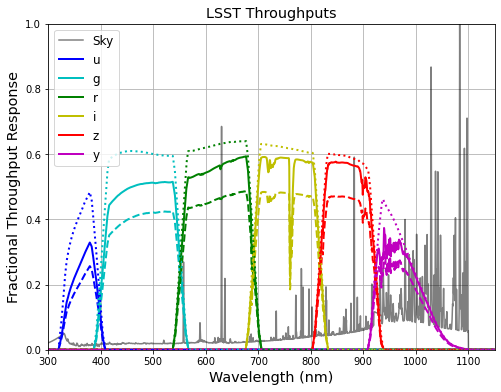

In [3]:
# Read the current throughput curves from the syseng_throughputs repository
throughputDirs = st.setDefaultDirs()

# Read dark sky and X=1 atmosphere
darksky = photUtils.Sed()
darksky.readSED_flambda(os.path.join(st.findRootDir(), 'siteProperties', 'darksky.dat'))
X = 1
atmosphere = st.readAtmosphere(throughputDirs['atmosphere'], atmosFile='atmos_10_aerosol.dat')

# Read components, directly from syseng_throughputs repository
throughputDirs = st.setDefaultDirs()

# Read throughput curves both with and without anticipated average losses over the lifetime of the LSST
hardware, system = st.buildHardwareAndSystem(throughputDirs, 
                                             atmosphereOverride=atmosphere, 
                                             addLosses=False)
hardware_loss, system_loss = st.buildHardwareAndSystem(throughputDirs, 
                                                       atmosphereOverride=atmosphere, 
                                                       addLosses=True)

# Set the current expected photometric parameters (readnoise/exposure time/etc)
readnoise = 8.8
darkcurrent = 0.2 # e-/s
# Photometric parameters for standard visits.
photParameters_15 = photUtils.PhotometricParameters(exptime=15, nexp=2, gain=1, 
                                                     readnoise=readnoise, othernoise=0, darkcurrent=darkcurrent)
photParameters_30 = photUtils.PhotometricParameters(exptime=30, nexp=1, gain=1,
                                                   readnoise=readnoise, othernoise=0, darkcurrent=darkcurrent)
# PhotometricParameters object for "no noise" visit - for dCm_infinity calculations
photParameters_infinity = photUtils.PhotometricParameters(exptime=15, nexp=2, gain=1.0, 
                                                      readnoise=0, darkcurrent=0, othernoise=0)

# Make it easier to retrieve the appropriate version per-bandpass for later
photParams = {}
photParams['u'] = photParameters_30
for f in ('g', 'r', 'i', 'z', 'y'):
    photParams[f] = photParameters_15

# Plot the throughput curves - dotted = throughputs without atmosphere, 
# solid = throughputs with atmosphere but no losses, dashed = throughputs with atmosphere and losses

plt.figure(figsize=(8,6))
plt.plot(darksky.wavelen, darksky.flambda/darksky.flambda.max(), 'k-', alpha=0.5, label='Sky')
st.plotBandpasses(system, 'LSST Throughputs', newfig=False, addlegend=True)
plt.legend(loc='upper left', fancybox=True, fontsize='large')
st.plotBandpasses(system_loss, newfig=False, linestyle='--', addlegend=False)
st.plotBandpasses(hardware, newfig=False, linestyle=':', addlegend=False)

In [4]:
# For the SRD values, we will use seeing and sky values from 
# the initial version of table 2 from the LSE-40 
# http://faculty.washington.edu/ivezic/Teaching/Astr511/LSST_SNRdoc.pdf
# (using y4 for y band)
# This matches the SRD statement of r band seeing = 0.7" and r band sky = 21.0, but expands per-wavelength

seeing_srd = {'u': 0.77,
             'g': 0.73,
             'r': 0.70,
             'i': 0.67,
             'z': 0.65,
             'y': 0.63}

skymag_srd = {'u': 22.92,
             'g': 22.27,
             'r': 21.20,
             'i': 20.47,
             'z': 19.59,
             'y': 18.63}
# ok .. even LSE-40 from above had sky in r band slightly darker, so adjust again.
for f in skymag_srd:
    skymag_srd[f] = skymag_srd[f] - 0.2
    
kAtm_srd = {'u': 0.451,
           'g': 0.163,
           'r': 0.087,
           'i': 0.065,
           'z': 0.043,
           'y': 0.138}
    
pd.DataFrame([seeing_srd, skymag_srd, kAtm_srd], index=['seeing SRD', 'skymag SRD', 'kAtm SRD'])

u       g       r       i       z       y
seeing SRD   0.770   0.730   0.700   0.670   0.650   0.630
skymag SRD  22.720  22.070  21.000  20.270  19.390  18.430
kAtm SRD     0.451   0.163   0.087   0.065   0.043   0.138

Calculate expected m5 values, Cm and dCm_infinity values, given these parameters.

In [5]:
## Utilities

def calcCm(m5, skyMag, fwhmEff, kAtm, expTimeTotal=30, X=1.0, m5_infinity=None):
    Cm = (m5 
          - 0.5 * (skyMag - 21) 
          - 2.5 * np.log10(0.7/fwhmEff) 
          - 1.25 * np.log10(expTimeTotal/30.0) 
          + kAtm * (X-1))
    if m5_infinity is not None:
        Cm_infinity = (m5_infinity 
                       - 0.5 * (skyMag - 21)
                       - 2.5 * np.log10(0.7/fwhmEff)
                       - 1.25 * np.log10(expTimeTotal/30.0)
                       + kAtm * (X-1))
        dCm_infinity = Cm_infinity - Cm
    else:
        dCm_infinity = None
    return Cm, dCm_infinity


def calcM5(hardware, system, skysed, skymags, fwhmEff, photParams):
    """Calculate m5 given the hardware, system and sky sed. 
    Also, skymags (dictionary or dataframe), fwhmEff (dictionary or dataframe), and single photParams.
    
    Call with photParams infinity (no noise) to calculate m5_infinity.
    """
    sky_copy = photUtils.Sed()
    sky_copy.setSED(wavelen = skysed.wavelen, flambda = skysed.flambda)
    m5 = {}
    for i,f in enumerate(skymags):
        fluxNorm = sky_copy.calcFluxNorm(skymags[f], hardware[f])
        sky_copy.multiplyFluxNorm(fluxNorm)
        m5[f] = photUtils.calcM5(sky_copy, system[f], hardware[f],
                                 photParams, FWHMeff=fwhmEff[f])
    return m5

def calc_dmag(param, newval, oldval, kAtm=None):
    """Evaluate the impact of a change in a given observing condition.
    
    Param == type of change (airmass, skybrightness, seeing).
    newval == new value of the parameter
    oldval == old value of the parameter 
    """
    if param == 'airmass':
        dmag = kAtm * (newval - oldval)
    elif param == 'skybrightness':
        dmag =  0.50 * (oldval - 21) - 0.50 * (newval - 21) 
    elif param == 'seeingFwhmEff':
        dmag = 2.5 * np.log10(0.7 /oldval) - 2.5 * np.log10(0.7 / newval) 
    else:
        print(param, 'unknown')
    return dmag

srd_time_distribution = {'u': 0.068, 'g': 0.097, 'r': 0.223, 'i': 0.223, 'z': 0.194, 'y': 0.194}
def calculate_effective_time(m5vals):
    "m5['srd'] is the reference value"
    weighted_time = {}
    for f in m5vals:
        dtime = np.power(10, -0.8 * (m5vals[f] - m5['srd'][f]))
        weighted_time[f] = dtime * srd_time_distribution[f]
    weighted_time['total'] = np.array(list(weighted_time.values())).sum()
    return weighted_time

In [6]:
# Calculate the expected limiting magnitudes and corresponding Cm values for the 
# SRD conditions + expected throughputs

m5 = {}
m5['srd min'] = m5_min
m5['srd'] = m5_fid
m5['srd system'] = {}

Cm = {}
Cm['srd min'] = {}
Cm['srd'] = {}
Cm['srd system'] = {}
dCm_infinity = {}
dCm_infinity['srd system'] = {}

for f in filterlist:
    Cm['srd min'][f], jj = calcCm(m5['srd min'][f], skymag_srd[f], seeing_srd[f], kAtm_srd[f], X=1.0)
    Cm['srd'][f], jj = calcCm(m5['srd'][f], skymag_srd[f], seeing_srd[f], kAtm_srd[f], X=1.0)



m5['srd system'] = calcM5(hardware, system, darksky, skymag_srd, seeing_srd, photParameters_15)
m5_infinity = calcM5(hardware, system, darksky, skymag_srd, seeing_srd, photParameters_infinity)
for f in filterlist:
    Cm['srd system'][f], dCm_infinity['srd system'][f] = calcCm(m5['srd system'][f], skymag_srd[f], 
                                                                seeing_srd[f], kAtm_srd[f], 
                                                                expTimeTotal=30, X=1.0, 
                                                                m5_infinity=m5_infinity[f])
    
keys = ['srd min', 'srd', 'srd system']

d = pd.DataFrame([m5[k] for k in keys] + [Cm[k] for k in keys] + [dCm_infinity['srd system']] + [seeing_srd, skymag_srd],
            index=[f'm5 {k}' for k in keys] + [f'Cm {k}' for k in keys] + ['dCm_infinity srd system'] 
                 + ['seeing srd', 'sky srd'])
d.round(2)

u      g      r      i      z      y
m5 srd min               23.40  24.60  24.30  23.60  22.90  21.70
m5 srd                   23.90  25.00  24.70  24.00  23.30  22.10
m5 srd system            24.23  25.08  24.58  24.15  23.58  22.70
Cm srd min               22.64  24.11  24.30  23.92  23.62  22.87
Cm srd                   23.14  24.51  24.70  24.32  24.02  23.27
Cm srd system            23.47  24.59  24.58  24.47  24.30  23.87
dCm_infinity srd system   0.43   0.13   0.07   0.05   0.03   0.02
seeing srd                0.77   0.73   0.70   0.67   0.65   0.63
sky srd                  22.72  22.07  21.00  20.27  19.39  18.43

In [7]:
# This gives us enough for an evaluation of the m5 and Cm values, as evaluated in the context of the SRD

# TABLE 1

d = pd.DataFrame([m5[k] for k in ['srd', 'srd min', 'srd system']] + 
                 [seeing_srd, skymag_srd, Cm['srd system'], dCm_infinity['srd system']],
                index=['SRD design', 'SRD minimum', 'm5 predicted', 
                       'seeing', 'skybrightness', 'Cm predicted', 'dCm_infinity'])
display(d.round(2))

print(d.round(2).to_latex())

u      g      r      i      z      y
SRD design     23.90  25.00  24.70  24.00  23.30  22.10
SRD minimum    23.40  24.60  24.30  23.60  22.90  21.70
m5 predicted   24.23  25.08  24.58  24.15  23.58  22.70
seeing          0.77   0.73   0.70   0.67   0.65   0.63
skybrightness  22.72  22.07  21.00  20.27  19.39  18.43
Cm predicted   23.47  24.59  24.58  24.47  24.30  23.87
dCm_infinity    0.43   0.13   0.07   0.05   0.03   0.02

\begin{tabular}{lrrrrrr}
\toprule
{} &      u &      g &      r &      i &      z &      y \\
\midrule
SRD design    &  23.90 &  25.00 &  24.70 &  24.00 &  23.30 &  22.10 \\
SRD minimum   &  23.40 &  24.60 &  24.30 &  23.60 &  22.90 &  21.70 \\
m5 predicted  &  24.23 &  25.08 &  24.58 &  24.15 &  23.58 &  22.70 \\
seeing        &   0.77 &   0.73 &   0.70 &   0.67 &   0.65 &   0.63 \\
skybrightness &  22.72 &  22.07 &  21.00 &  20.27 &  19.39 &  18.43 \\
Cm predicted  &  23.47 &  24.59 &  24.58 &  24.47 &  24.30 &  23.87 \\
dCm\_infinity  &   0.43 &   0.13 &   0.07 &   0.05 &   0.03 &   0.02 \\
\bottomrule
\end{tabular}



In [8]:
# A side-trip to look at the total effective survey time, for the minimum/design/SRD-referenced system
teff_srd_min = calculate_effective_time(m5['srd min']) 
teff_srd_design = calculate_effective_time(m5['srd'])
teff_srd_system = calculate_effective_time(m5['srd system'])
pd.DataFrame([m5['srd min'], teff_srd_min, m5['srd'], teff_srd_design, m5['srd system'], teff_srd_system], 
             index=['m5 srd min', 'teff srd min', 'm5 srd', 'teff srd', 'm5 srd system', 'teff srd system'])

u       g       r       i       z       y  total
m5 srd min       23.400  24.600  24.300  23.600  22.900  21.700    NaN
teff srd min      0.171   0.203   0.466   0.466   0.405   0.405  2.116
m5 srd           23.900  25.000  24.700  24.000  23.300  22.100    NaN
teff srd          0.068   0.097   0.223   0.223   0.194   0.194  0.999
m5 srd system    24.226  25.081  24.580  24.153  23.580  22.700    NaN
teff srd system   0.037   0.084   0.278   0.168   0.116   0.064  0.747

In [9]:
# While we're here, calculate updated kAtm and skyMag values for the actual throughput curves and dark sky sed.
Tb = {}
Sb = {}
kAtm = {}
skyMag = {}
for f in filterlist:
    dwavelen = np.unique(np.diff(system[f].wavelen)).mean()
    Tb[f] = np.sum(system[f].sb / system[f].wavelen) * dwavelen
    Sb[f] = np.sum(hardware[f].sb / hardware[f].wavelen) * dwavelen
    kAtm[f] = -2.5 * np.log10(Tb[f] / Sb[f]) / X
    # Can calculate skyMag here too as it is atmosphere and seeing independent 
    skyMag[f] = darksky.calcMag(hardware[f])
pd.DataFrame([kAtm_srd, kAtm], 
             index=['kAtm SRD', 'kAtm system']).round(2)

u     g     r     i     z     y
kAtm SRD     0.45  0.16  0.09  0.06  0.04  0.14
kAtm system  0.50  0.21  0.13  0.10  0.07  0.17

(note that I will switch from kAtm_SRD to kAtm_system below; however for calculating Cm at X=1, it doesn't matter as X-1 = 0). 

## Progressing towards operations ##

As we progress towards operations, we are learning more about the system.

This includes learning about the delivered point spread function (PSF), the expected losses over the lifetime of the survey, and about the survey strategy (and thus range of seeing, skybrightness, and airmass conditions for observing).

### PSF ###

The initial assumptions for the SRD evaluation of the expected seeing included an atmospheric contribution of 0.6" (median value from histogram in SRD), together with some contributions from the telescope, optical design, and camera. The initial assumption of the PSF profile was that it would be a simple gaussian. Further evaluation of the PSF has shown that we should expect a vanKarmen profile, which has a more complicated shape. For SNR calculation purposes, a vanKarmen profile can be described in terms of an "equivalent Gaussian FWHM" value that, when used to calculate SNR, results in the same SNR as the actual vanKarmen profile.  This equivalent FWHM (`fwhmEff`) is larger than the geometric FWHM equivalent (`fwhmGeom`). 

We can recreate the seeing values from the SRD, with the atmospheric component = 0.6", if we both assume we're looking at fwhmGeom and that the contributions from the telescope and camera are slightly better than current requirements.

In [10]:
seeing_model = site_models.SeeingModel(telescope_seeing=0.25, optical_design_seeing=0.08, camera_seeing=0.30)
srd_seeing_model = site_models.SeeingModel(telescope_seeing=0.2, optical_design_seeing=0.08, camera_seeing=0.27)

In [11]:
pd.DataFrame([seeing_srd, dict(zip(filterlist, srd_seeing_model(0.6, 1)['fwhmGeom']))], 
               index=['seeing SRD', 'model SRD seeing (fwhmGeom)']).round(2)

u     g     r     i     z     y
seeing SRD                   0.77  0.73  0.70  0.67  0.65  0.63
model SRD seeing (fwhmGeom)  0.77  0.73  0.69  0.66  0.65  0.63

So we know that the camera and telescope contributions should be slightly larger, and we also know that we have updated FWHM500 values (from 0.6" to 0.72") once we add a longer database of seeing values (see RTN-022).

In [12]:
# Now we know how to model the SRD seeing, we can evaluate the impact of the changing telescope/camera contribution
# and then the update in the mean FWHM
seeing_srd_fwhmEff = dict(zip(filterlist, srd_seeing_model(0.6, 1)['fwhmEff']))
# 0.72" is the updated FWHM500 once a longer timespan is used for the input database
seeing_sim = dict(zip(filterlist, seeing_model(0.72, 1)['fwhmEff']))

see = pd.DataFrame([seeing_srd, seeing_srd_fwhmEff, seeing_sim, dict(zip(filterlist, seeing_model(0.72, 1)['fwhmGeom']))], 
            index=['seeing SRD', 'seeing SRD fwhmEff', 'updated seeing', 
                   'for reference .. updated seeing (fwhmGeom)'])
see.round(2)

u     g     r     i     z     y
seeing SRD                                  0.77  0.73  0.70  0.67  0.65  0.63
seeing SRD fwhmEff                          0.88  0.82  0.78  0.74  0.72  0.71
updated seeing                              1.04  0.98  0.92  0.88  0.86  0.84
for reference .. updated seeing (fwhmGeom)  0.91  0.86  0.81  0.78  0.76  0.74

In [13]:
k = 'system with updated PSF'

m5[k] = calcM5(hardware, system, darksky, skymag_srd, seeing_srd_fwhmEff, photParameters_15)
m5_infinity = calcM5(hardware, system, darksky, skymag_srd, seeing_srd_fwhmEff, photParameters_infinity)

Cm[k] = {}
dCm_infinity[k] = {}
for f in filterlist:
    Cm[k][f], dCm_infinity[k][f] = calcCm(m5[k][f], skymag_srd[f], 
                                                                seeing_srd_fwhmEff[f], kAtm[f], 
                                                                expTimeTotal=30, X=1.0, 
                                                                m5_infinity=m5_infinity[f])
    
keys = ['srd', 'srd system', 'system with updated PSF']
pd.DataFrame([m5[k] for k in keys] + [Cm[k] for k in keys],
            index=[f'm5 {k}' for k in keys] + [f'Cm {k}' for k in keys])

u       g       r       i       z       y
m5 srd                      23.900  25.000  24.700  24.000  23.300  22.100
m5 srd system               24.226  25.081  24.580  24.153  23.580  22.700
m5 system with updated PSF  24.090  24.954  24.470  24.040  23.466  22.577
Cm srd                      23.143  24.511  24.700  24.317  24.025  23.271
Cm srd system               23.470  24.592  24.580  24.471  24.304  23.870
Cm system with updated PSF  23.473  24.594  24.582  24.472  24.305  23.871

In [14]:
k = 'system with updated seeing'

m5[k] = calcM5(hardware, system, darksky, skymag_srd, seeing_sim, photParameters_15)
m5_infinity = calcM5(hardware, system, darksky, skymag_srd, seeing_sim, photParameters_infinity)

Cm[k] = {}
dCm_infinity[k] = {}
for f in filterlist:
    Cm[k][f], dCm_infinity[k][f] = calcCm(m5[k][f], skymag_srd[f], 
                                                                seeing_sim[f], kAtm[f], 
                                                                expTimeTotal=30, X=1.0, 
                                                                m5_infinity=m5_infinity[f])
    
keys = ['srd', 'srd system', 'system with updated PSF', 'system with updated seeing']
d = pd.DataFrame([m5[k] for k in keys] + [Cm[k] for k in keys],
            index=[f'm5 {k}' for k in keys] + [f'Cm {k}' for k in keys])
d.round(2)

u      g      r      i      z      y
m5 srd                         23.90  25.00  24.70  24.00  23.30  22.10
m5 srd system                  24.23  25.08  24.58  24.15  23.58  22.70
m5 system with updated PSF     24.09  24.95  24.47  24.04  23.47  22.58
m5 system with updated seeing  23.90  24.77  24.29  23.86  23.28  22.39
Cm srd                         23.14  24.51  24.70  24.32  24.02  23.27
Cm srd system                  23.47  24.59  24.58  24.47  24.30  23.87
Cm system with updated PSF     23.47  24.59  24.58  24.47  24.31  23.87
Cm system with updated seeing  23.48  24.60  24.58  24.47  24.31  23.87

In [15]:
dmag_system = {}
dmag_system['psf update'] = dict(d.loc['m5 srd system'] - d.loc['m5 system with updated PSF'])
dmag_system['fwhm500 update'] = dict(d.loc['m5 system with updated PSF'] - d.loc['m5 system with updated seeing'])
pd.DataFrame(dmag_system).round(2).T

u     g     r     i     z     y
psf update      0.14  0.13  0.11  0.11  0.11  0.12
fwhm500 update  0.19  0.19  0.18  0.18  0.18  0.18

### Dark sky update ###

The skybrightness model predicts slightly different dark sky values, beyond the dark sky sed.
The differences are small. 

In [16]:
# Note that this difference is primarily due to the fact that the skybrightness model is fitting observed
# sky values from the site and near the site -- instead of fitting an expected SED to older skybrightness
# values from a different site
# These are still zenith (X~1) values
# values pulled from https://github.com/lsst/rubin_sim_notebooks/blob/main/maf/science/teff_fiducial.ipynb
dark_sky = {'u': 22.68,
           'g': 22.11,
           'r': 21.11,
           'i': 20.39,
           'z': 19.43,
           'y': 18.63}

pd.DataFrame([skymag_srd, dark_sky], index=['dark sky SRD', 'dark sky sims_skybrightness'])

u      g      r      i      z      y
dark sky SRD                 22.72  22.07  21.00  20.27  19.39  18.43
dark sky sims_skybrightness  22.68  22.11  21.11  20.39  19.43  18.63

In [17]:
k = 'system with updated darksky'

m5[k] = calcM5(hardware, system, darksky, dark_sky, seeing_srd, photParameters_15)
m5_infinity = calcM5(hardware, system, darksky, dark_sky, seeing_srd, photParameters_infinity)

Cm[k] = {}
dCm_infinity[k] = {}
for f in filterlist:
    Cm[k][f], dCm_infinity[k][f] = calcCm(m5[k][f], dark_sky[f], 
                                                                seeing_srd[f], kAtm[f], 
                                                                expTimeTotal=30, X=1.0, 
                                                                m5_infinity=m5_infinity[f])
    
keys = ['srd', 'srd system', 'system with updated darksky']
d = pd.DataFrame([m5[k] for k in keys] + [Cm[k] for k in keys],
            index=[f'm5 {k}' for k in keys] + [f'Cm {k}' for k in keys])
d.round(2)

u      g      r      i      z      y
m5 srd                          23.90  25.00  24.70  24.00  23.30  22.10
m5 srd system                   24.23  25.08  24.58  24.15  23.58  22.70
m5 system with updated darksky  24.22  25.10  24.63  24.21  23.60  22.79
Cm srd                          23.14  24.51  24.70  24.32  24.02  23.27
Cm srd system                   23.47  24.59  24.58  24.47  24.30  23.87
Cm system with updated darksky  23.48  24.59  24.57  24.46  24.30  23.86

In [18]:
dmag_system['dark sky update'] = dict(d.loc['m5 srd system'] - d.loc['m5 system with updated darksky'])
pd.DataFrame(dmag_system).T.round(2)

u     g     r     i     z     y
psf update       0.14  0.13  0.11  0.11  0.11  0.12
fwhm500 update   0.19  0.19  0.18  0.18  0.18  0.18
dark sky update  0.01 -0.02 -0.05 -0.05 -0.02 -0.09

### Contamination losses over time ###

The system also suffers contamination losses over the lifetime of the LSST. The values used here are the average over 10 years, although these are not linear with time (often the actual losses will follow a sawtooth pattern, between maintenance intervals). 

In [19]:
k = 'srd system with losses'

m5[k] = calcM5(hardware_loss, system_loss, darksky, skymag_srd, seeing_srd, photParameters_15)
m5_infinity = calcM5(hardware_loss, system_loss, darksky, skymag_srd, seeing_srd, photParameters_infinity)

Cm[k] = {}
dCm_infinity[k] = {}
for f in filterlist:
    Cm[k][f], dCm_infinity[k][f] = calcCm(m5[k][f], skymag_srd[f], 
                                                                seeing_srd[f], kAtm_srd[f], 
                                                                expTimeTotal=30, X=1.0, 
                                                                m5_infinity=m5_infinity[f])
    
keys = ['srd', 'srd system', 'srd system with losses']
d = pd.DataFrame([m5[k] for k in keys] + [Cm[k] for k in keys],
            index=[f'm5 {k}' for k in keys] + [f'Cm {k}' for k in keys])
d.round(2)

u      g      r      i      z      y
m5 srd                     23.90  25.00  24.70  24.00  23.30  22.10
m5 srd system              24.23  25.08  24.58  24.15  23.58  22.70
m5 srd system with losses  24.02  24.94  24.46  24.03  23.46  22.59
Cm srd                     23.14  24.51  24.70  24.32  24.02  23.27
Cm srd system              23.47  24.59  24.58  24.47  24.30  23.87
Cm srd system with losses  23.26  24.45  24.46  24.35  24.19  23.76

In [20]:
# The system losses are then:
dmag_system['contamination losses'] = dict(d.loc['m5 srd system'] - d.loc['m5 srd system with losses'])
pd.DataFrame(dmag_system).T.round(2)

u     g     r     i     z     y
psf update            0.14  0.13  0.11  0.11  0.11  0.12
fwhm500 update        0.19  0.19  0.18  0.18  0.18  0.18
dark sky update       0.01 -0.02 -0.05 -0.05 -0.02 -0.09
contamination losses  0.21  0.14  0.12  0.12  0.12  0.11

### 30s u band visits ###

And then one more all-cadence optimization we'll add into the reference system is using 2x15s visits in all EXCEPT u band, which will be 1x30s.

In [21]:
# Calculate dark sky, X=1.0, srd_fiducial seeing m5 and Cm values 
# "throughputs" == throughput components, X=1.0, dark sky sed, 
#  and fiducial seeing (corresponds to 0.62" 500nm zenith seeing)
# ""fiducial"" may be not quite right.. this is the value that has been kicking around for a few yearse
# and is used in various defaults (rubin_sim.photUtils.LSSTdefaults, etc.) and Document-20160 (seeing by Bo)

# NOTE using dark_sky for this estimate

k = '30s uband system'

m5[k] = calcM5(hardware, system, darksky, dark_sky, seeing_srd, photParameters_15)
u = calcM5(hardware, system, darksky, dark_sky, seeing_srd, photParameters_30)
m5[k]['u'] = u['u']
m5_infinity = calcM5(hardware, system, darksky, dark_sky, seeing_srd, photParameters_infinity)

Cm[k] = {}
dCm_infinity[k] = {}
for f in filterlist:
    Cm[k][f], dCm_infinity[k][f] = calcCm(m5[k][f], dark_sky[f], 
                                                                seeing_srd[f], kAtm_srd[f], 
                                                                expTimeTotal=30, X=1.0, 
                                                                m5_infinity=m5_infinity[f])
    
keys = ['srd', 'srd system', 'system with updated darksky', '30s uband system']
d = pd.DataFrame([m5[k] for k in keys] + [Cm[k] for k in keys],
            index=[f'm5 {k}' for k in keys] + [f'Cm {k}' for k in keys])
d.round(2)

u      g      r      i      z      y
m5 srd                          23.90  25.00  24.70  24.00  23.30  22.10
m5 srd system                   24.23  25.08  24.58  24.15  23.58  22.70
m5 system with updated darksky  24.22  25.10  24.63  24.21  23.60  22.79
m5 30s uband system             24.38  25.10  24.63  24.21  23.60  22.79
Cm srd                          23.14  24.51  24.70  24.32  24.02  23.27
Cm srd system                   23.47  24.59  24.58  24.47  24.30  23.87
Cm system with updated darksky  23.48  24.59  24.57  24.46  24.30  23.86
Cm 30s uband system             23.64  24.59  24.57  24.46  24.30  23.86

In [22]:
# The system losses are then:
dmag_system['30s uband system'] = dict(d.loc['m5 system with updated darksky'] - d.loc['m5 30s uband system'])
pd.DataFrame(dmag_system).T.round(2)

u     g     r     i     z     y
psf update            0.14  0.13  0.11  0.11  0.11  0.12
fwhm500 update        0.19  0.19  0.18  0.18  0.18  0.18
dark sky update       0.01 -0.02 -0.05 -0.05 -0.02 -0.09
contamination losses  0.21  0.14  0.12  0.12  0.12  0.11
30s uband system     -0.16  0.00  0.00  0.00  0.00  0.00

In [23]:
## Now write this up, as a table of dmag values corresponding to each change, for table 2 

k = 'sim reference'

m5[k] = calcM5(hardware_loss, system_loss, darksky, dark_sky, seeing_sim, photParameters_15)
u = calcM5(hardware_loss, system_loss, darksky, dark_sky, seeing_sim, photParameters_30)
m5[k]['u'] = u['u']
m5_infinity = calcM5(hardware_loss, system_loss, darksky, dark_sky, seeing_sim, photParameters_infinity)

Cm[k] = {}
dCm_infinity[k] = {}
for f in filterlist:
    Cm[k][f], dCm_infinity[k][f] = calcCm(m5[k][f], dark_sky[f],
                                          seeing_sim[f], kAtm[f],
                                          expTimeTotal=30, X=1.0, 
                                          m5_infinity=m5_infinity[f])
keys = ['srd min', 'srd', 'srd system', 'sim reference']
d = pd.DataFrame([m5[k] for k in keys],
            index=[f'm5 {k}' for k in keys])
d.round(2)

u      g      r      i      z      y
m5 srd min        23.40  24.60  24.30  23.60  22.90  21.70
m5 srd            23.90  25.00  24.70  24.00  23.30  22.10
m5 srd system     24.23  25.08  24.58  24.15  23.58  22.70
m5 sim reference  23.87  24.64  24.21  23.79  23.18  22.37

In [55]:
dmag_system['combined'] = {}
for f in filterlist:
    dmag_system['combined'][f] = (dmag_system['psf update'][f] + 
                                      dmag_system['fwhm500 update'][f] + 
                                      dmag_system['dark sky update'][f] + 
                                      dmag_system['contamination losses'][f] + 
                                      dmag_system['30s uband system'][f])

In [56]:
## TABLE 2

d = pd.DataFrame([m5['srd system'], dmag_system['psf update'], 
                  dmag_system['fwhm500 update'], dmag_system['dark sky update'], 
                  dmag_system['contamination losses'],
                  dmag_system['30s uband system'], 
                  dmag_system['combined'], 
                  m5['sim reference']],
                index=['m5 SRD system', '$\Delta m$ PSF profile update',
                      '$\Delta m$ median FWHM500 update', 
                       '$\Delta m$ dark sky update',
                      '$\Delta m$ system losses',
                      '$\Delta m$ 1x30s u band',
                       '$\Delta m$ combined',
                      'm5 simulation reference'])
display(d.round(2))

print(d.round(2).to_latex())

u      g      r      i      z      y
m5 SRD system                     24.23  25.08  24.58  24.15  23.58  22.70
$\Delta m$ PSF profile update      0.14   0.13   0.11   0.11   0.11   0.12
$\Delta m$ median FWHM500 update   0.19   0.19   0.18   0.18   0.18   0.18
$\Delta m$ dark sky update         0.01  -0.02  -0.05  -0.05  -0.02  -0.09
$\Delta m$ system losses           0.21   0.14   0.12   0.12   0.12   0.11
$\Delta m$ 1x30s u band           -0.16   0.00   0.00   0.00   0.00   0.00
$\Delta m$ combined                0.38   0.44   0.37   0.36   0.40   0.33
m5 simulation reference           23.87  24.64  24.21  23.79  23.18  22.37

\begin{tabular}{lrrrrrr}
\toprule
{} &      u &      g &      r &      i &      z &      y \\
\midrule
m5 SRD system                    &  24.23 &  25.08 &  24.58 &  24.15 &  23.58 &  22.70 \\
\$\textbackslash Delta m\$ PSF profile update    &   0.14 &   0.13 &   0.11 &   0.11 &   0.11 &   0.12 \\
\$\textbackslash Delta m\$ median FWHM500 update &   0.19 &   0.19 &   0.18 &   0.18 &   0.18 &   0.18 \\
\$\textbackslash Delta m\$ dark sky update       &   0.01 &  -0.02 &  -0.05 &  -0.05 &  -0.02 &  -0.09 \\
\$\textbackslash Delta m\$ system losses         &   0.21 &   0.14 &   0.12 &   0.12 &   0.12 &   0.11 \\
\$\textbackslash Delta m\$ 1x30s u band          &  -0.16 &   0.00 &   0.00 &   0.00 &   0.00 &   0.00 \\
\$\textbackslash Delta m\$ combined              &   0.38 &   0.44 &   0.37 &   0.36 &   0.40 &   0.33 \\
m5 simulation reference          &  23.87 &  24.64 &  24.21 &  23.79 &  23.18 &  22.37 \\
\bottomrule
\end{tabular}



In [57]:
## double check
dm = {}
newm5 = {}
for f in filterlist:
    dm[f] = 0
    for k in dmag_system:
        dm[f] -= dmag_system[k][f]
    newm5[f] = m5['srd system'][f] + dm[f]
pd.DataFrame([m5['sim reference'], newm5], index=['sim ref', 'updated m5']).round(2)

u      g      r      i      z      y
sim ref     23.87  24.64  24.21  23.79  23.18  22.37
updated m5  23.47  24.21  23.84  23.43  22.79  22.05

## Add simulations of survey cadence ##

First, we note that the code used to calculate the m5 depths in the simulations is slightly different than the calculation above. For both speed and to be able to calculate m5 depths in all ranges of airmass, seeing, and sky brightness, we use the Cm equation referenced above to calculate m5. Thus it's important to note the values of Cm being used to calculate m5 depths coming from the opsim outputs, and to verify that they match the Cm values that would be generated by our current throughputs.

In [26]:
# What values for Cm are used in the cadence simulations?
# These are calculated based on 30s visits and X=1.2 -- see below 
# (SysEngVals is the piece of code we store the refence numbers, but is calculated as in next cell)

vals = rsUtils.SysEngVals()
Cm_cadence_reference = vals.Cm

# The reference values can be recreated as follows:
Cm_cadence_calc = {}
fid_fwhmEff = {}
for f in filterlist:
    fid_fwhmEff[f] = photUtils.LSSTdefaults().FWHMeff(f)
    
sky_mag = {}
for f in filterlist:
    sky_mag[f] = darksky.calcMag(hardware_loss[f])
    
m5_tmp = calcM5(hardware_loss, system_loss, darksky, sky_mag, fid_fwhmEff, photParameters_30)

for f in filterlist:
    Cm_cadence_calc[f], jj = calcCm(m5_tmp[f], sky_mag[f], fid_fwhmEff[f], kAtm[f], expTimeTotal=30, X=1.0)

pd.DataFrame([Cm_cadence_reference, Cm_cadence_calc], 
             index=['Cm cadence reference', 'Cm cadence calculated']).round(2)

u      g      r      i     z      y
Cm cadence reference   23.39  24.51  24.49  24.37  24.2  23.77
Cm cadence calculated  23.39  24.51  24.49  24.37  24.2  23.77

In [27]:
# The Cm cadence values above are used for simulations, but are scaled appropriately for the given exposure time 
# and conditions. The scaling can introduce errors up to but typically less than 0.01 magnitudes.
# We use rubin_sim.utils.m5_flat_sed for this scaling.

k = 'cadence reference'
m5[k] = {}
Cm[k] = Cm_cadence_reference

for f in filterlist:
    if f == 'u':
        expTime = 30
        nexp = 1
    else:
        expTime = 15
        nexp = 2
    m5[k][f] = rsUtils.m5_flat_sed(f, dark_sky[f], seeing_sim[f], expTime=expTime, airmass=1.0, nexp=nexp)
    
keys = ['srd', 'srd system', 'sim reference', 'cadence reference']
pd.DataFrame([m5[k] for k in keys],
            index=[f'm5 {k}' for k in keys]).round(2)

u      g      r      i      z      y
m5 srd                23.90  25.00  24.70  24.00  23.30  22.10
m5 srd system         24.23  25.08  24.58  24.15  23.58  22.70
m5 sim reference      23.87  24.64  24.21  23.79  23.18  22.37
m5 cadence reference  23.86  24.63  24.21  23.79  23.18  22.37

The Cm values in the simulation ('vals') are appropriate for use in the scaling function, and match what is expected from the system throughputs, as calculated above ('Cm cadence reference'). The m5 values above are calculated for the appropriate exposure time and number of exposures per visit, consistent with the 'sim reference'.

## Evaluating m5 depths in cadence outputs. ##

In practice, the LSST observations will cover a range of airmasses, skybrightness, and seeing values, which will all impact the five sigma point source magnitude limit (m5). The conditions above are for dark sky and zenith (X=1) conditions; real-world observations would result in m5 values which are shallower, as airmass and sky brightness can only increase. The seeing above is a median, so sometimes we will acquire images with better seeing and thus potentially fainter m5 values. These ranges can be influenced by survey strategy, but only up to an given extent as we will use all available time (and thus have to accept a range of sky brightness and seeing). 

In addition, the final coadded depth is dependent on the number of visits acquired at any point in the sky, which is strongly dependent on survey strategy, although again has limitations around the total survey lifetime, minimum survey area, and observing duty-cycle requirements. 

In [28]:
# In an implemented survey, such as baseline_v2.0_10yrs -- 
# we have a range of airmasses, seeing, and skybrightness values

# Pull up median values of each of these

opsim_db_file = get_baseline()
runName = os.path.split(opsim_db_file)[-1].replace('.db', '')
outDir = 'm5_metrics'
resultsDb = maf.ResultsDb(outDir)
print(runName)

baseline_v2.0_10yrs


In [29]:
colmap = maf.ColMapDict()
colmap['skyBrightness'], colmap['seeingEff'], colmap['fiveSigmaDepth']

('skyBrightness', 'seeingFwhmEff', 'fiveSigmaDepth')

In [30]:
# Identify WFD footprint
nside = 64
footprint = maf.MetricBundle(maf.CountMetric('observationStartMJD', metricName='nvisits'), 
                            maf.HealpixSlicer(nside=nside), constraint=None, runName=runName)
g = maf.MetricBundleGroup({'footprint': footprint}, opsim_db_file, outDir=outDir, resultsDb=resultsDb)
g.runAll()
wfd_footprint = np.where(footprint.metricValues.filled(0) >= 750, footprint.metricValues.filled(0), 0)

allsky_slicer = maf.HealpixSlicer(nside=nside)
wfd_slicer = maf.HealpixSubsetSlicer(nside=nside, hpid=np.where(wfd_footprint>0)[0])

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying table None with no constraint for columns ['fieldDec', 'observationStartMJD', 'fieldRA', 'rotSkyPos'].
Found 2086980 visits
Running:  ['footprint']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


area in wfd footprint 18620.568812654947


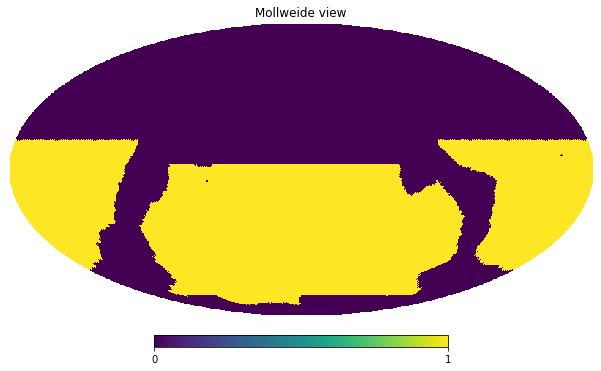

In [31]:
print('area in wfd footprint', len(np.where(wfd_footprint>0)[0]) * hp.nside2pixarea(nside, degrees=True))
hp.mollview(np.where(wfd_footprint>0, 1, 0))

In [32]:
b = {}
b['median fwhm_500'] = maf.MetricBundle(maf.MedianMetric('seeingFwhm500'), maf.UniSlicer(), None)
b['fwhm_500 histogram'] = maf.MetricBundle(maf.CountMetric('seeingFwhm500'),
                                                maf.OneDSlicer('seeingFwhm500'), None)

filtercolors = {"u": "cyan", "g": "g", "r": "orange", "i": "r", "z": "m", "y": "b", 'all': 'k'}
for f in filterlist:
    sql = f'filter == "{f}"'
    plotDict = {'color': filtercolors[f]}
    b[f'median airmass {f}'] = maf.MetricBundle(maf.MedianMetric('airmass'),
                                      maf.UniSlicer(), sql)
    b[f'25th percentile airmass {f}'] = maf.MetricBundle(maf.PercentileMetric('airmass', percentile=25),
                                      maf.UniSlicer(), sql)
    b[f'75th percentile airmass {f}'] = maf.MetricBundle(maf.PercentileMetric('airmass', percentile=75),
                                      maf.UniSlicer(), sql)                                                        
    b[f'airmass histogram {f}'] = maf.MetricBundle(maf.CountMetric('airmass'),
                                         maf.OneDSlicer('airmass'), sql)
    b[f'median skybrightness {f}'] = maf.MetricBundle(maf.MedianMetric('skyBrightness'), maf.UniSlicer(), sql)
    b[f'25th percentile skybrightness {f}'] = maf.MetricBundle(maf.PercentileMetric('skyBrightness', percentile=25),
                                      maf.UniSlicer(), sql)
    b[f'75th percentile skybrightness {f}'] = maf.MetricBundle(maf.PercentileMetric('skyBrightness', percentile=75),
                                      maf.UniSlicer(), sql)
    b[f'skybrightness histogram {f}'] = maf.MetricBundle(maf.CountMetric('skyBrightness'),
                                                        maf.OneDSlicer('skyBrightness'), sql)
    b[f'median seeingFwhmEff {f}'] = maf.MetricBundle(maf.MedianMetric('seeingFwhmEff'), maf.UniSlicer(), sql)
    b[f'25th percentile seeingFwhmEff {f}'] = maf.MetricBundle(maf.PercentileMetric('seeingFwhmEff', percentile=25),
                                      maf.UniSlicer(), sql)
    b[f'75th percentile seeingFwhmEff {f}'] = maf.MetricBundle(maf.PercentileMetric('seeingFwhmEff', percentile=75),
                                      maf.UniSlicer(), sql)
    b[f'seeingFwhmEff histogram {f}'] = maf.MetricBundle(maf.CountMetric('seeingFwhmEff'),
                                                    maf.OneDSlicer('seeingFwhmEff'), sql)
    b[f'median m5 {f}'] = maf.MetricBundle(maf.MedianMetric('fiveSigmaDepth'), maf.UniSlicer(), sql)
    b[f'25th percentile m5 {f}'] = maf.MetricBundle(maf.PercentileMetric('fiveSigmaDepth', percentile=25),
                                      maf.UniSlicer(), sql)
    b[f'75th percentile m5 {f}'] = maf.MetricBundle(maf.PercentileMetric('fiveSigmaDepth', percentile=75),
                                      maf.UniSlicer(), sql)
    b[f'm5 histogram {f}'] = maf.MetricBundle(maf.CountMetric('fiveSigmaDepth'),
                                                maf.OneDSlicer('fiveSigmaDepth'), sql)
    b[f'median visit m5 {f}'] = maf.MetricBundle(maf.MedianMetric('fiveSigmaDepth'),
                                                allsky_slicer, sql, info_label='all sky',
                                                summaryMetrics=[maf.MedianMetric()])
    b[f'wfd median visit m5 {f}'] = maf.MetricBundle(maf.MedianMetric('fiveSigmaDepth'),
                                                wfd_slicer, sql, info_label='wfd',
                                                summaryMetrics=[maf.MedianMetric()])
    b[f'wfd 25th percentile visit m5 {f}'] = maf.MetricBundle(maf.PercentileMetric('fiveSigmaDepth', percentile=25),
                                                wfd_slicer, sql, info_label='wfd',
                                                summaryMetrics=[maf.MedianMetric()])
    b[f'wfd 75th percentile visit m5 {f}'] = maf.MetricBundle(maf.PercentileMetric('fiveSigmaDepth', percentile=75),
                                                wfd_slicer, sql, info_label='wfd',
                                                summaryMetrics=[maf.MedianMetric()])
    b[f'coadd m5 {f}'] = maf.MetricBundle(maf.Coaddm5Metric(), allsky_slicer, sql,
                                          info_label='all sky',
                                         summaryMetrics=[maf.MedianMetric()])
    b[f'wfd coadd m5 {f}'] = maf.MetricBundle(maf.Coaddm5Metric(), wfd_slicer, sql,
                                          info_label='wfd',
                                         summaryMetrics=[maf.MedianMetric(), 
                                                         maf.PercentileMetric(percentile=25),
                                                        maf.PercentileMetric(percentile=75)])
    b[f'Nvisits {f}'] = maf.MetricBundle(maf.CountMetric('observationStartMJD'),
                                            allsky_slicer, sql, info_label='all sky',
                                            summaryMetrics=[maf.MedianMetric()])
    b[f'wfd Nvisits {f}'] = maf.MetricBundle(maf.CountMetric('observationStartMJD'),
                                            wfd_slicer, sql, info_label='wfd',
                                            summaryMetrics=[maf.MedianMetric(), 
                                                            maf.PercentileMetric(percentile=25), 
                                                            maf.PercentileMetric(percentile=75)])
for f in ['all']:
    sql = None
    plotDict = {'color': filtercolors[f]}
    b[f'median airmass {f}'] = maf.MetricBundle(maf.MedianMetric('airmass'),
                                      maf.UniSlicer(), sql)
    b[f'airmass histogram {f}'] = maf.MetricBundle(maf.CountMetric('airmass'),
                                         maf.OneDSlicer('airmass'), sql)
    b[f'median skybrightness {f}'] = maf.MetricBundle(maf.MedianMetric('skyBrightness'), maf.UniSlicer(), sql)
    b[f'skybrightness histogram {f}'] = maf.MetricBundle(maf.CountMetric('skyBrightness'),
                                                        maf.OneDSlicer('skyBrightness'), sql)
    b[f'median seeingFwhmEff {f}'] = maf.MetricBundle(maf.MedianMetric('seeingFwhmEff'), maf.UniSlicer(), sql)
    b[f'seeingFwhmEff histogram {f}'] = maf.MetricBundle(maf.CountMetric('seeingFwhmEff'),
                                                    maf.OneDSlicer('seeingFwhmEff'), sql)
    b[f'Nvisits {f}'] = maf.MetricBundle(maf.CountMetric('observationStartMJD'),
                                            allsky_slicer, sql, info_label='all sky',
                                            summaryMetrics=[maf.MedianMetric()])
    b[f'wfd Nvisits {f}'] = maf.MetricBundle(maf.CountMetric('observationStartMJD'),
                                            wfd_slicer, sql, info_label='wfd sky',
                                            summaryMetrics=[maf.MedianMetric(),
                                                            maf.PercentileMetric(percentile=25),
                                                            maf.PercentileMetric(percentile=75)])
for k in b:
    b[k].setRunName(runName)

In [33]:
g = maf.MetricBundleGroup(b, opsim_db_file, outDir, None, dbTable='observations')
g.runAll()

Querying table observations with no constraint for columns ['fieldRA', 'airmass', 'skyBrightness', 'fieldDec', 'seeingFwhmEff', 'rotSkyPos', 'observationStartMJD', 'seeingFwhm500'].
Found 2086980 visits
Running:  ['median fwhm_500', 'median airmass all', 'median skybrightness all', 'median seeingFwhmEff all']
Completed metric generation.
Running:  ['fwhm_500 histogram']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 1490 bins, returning 200
  warnings.warn(


Completed metric generation.
Running:  ['airmass histogram all']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 569 bins, returning 200
  warnings.warn(


Completed metric generation.
Running:  ['skybrightness histogram all']
Completed metric generation.
Running:  ['seeingFwhmEff histogram all']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 1282 bins, returning 200
  warnings.warn(


Completed metric generation.
Running:  ['Nvisits all']
Completed metric generation.
Running:  ['wfd Nvisits all']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table observations with constraint filter == "g" for columns ['fieldRA', 'airmass', 'fiveSigmaDepth', 'skyBrightness', 'fieldDec', 'seeingFwhmEff', 'rotSkyPos', 'observationStartMJD']
Found 217817 visits
Running:  ['median airmass g', '25th percentile airmass g', '75th percentile airmass g', 'median skybrightness g', '25th percentile skybrightness g', '75th percentile skybrightness g', 'median seeingFwhmEff g', '25th percentile seeingFwhmEff g', '75th percentile seeingFwhmEff g', 'median m5 g', '25th percentile m5 g', '75th percentile m5 g']
Completed metric generation.
Running:  ['airmass histogram g']
Completed metric generation.
Running:  ['skybrightness histogram g']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 270 bins, returning 200
  warnings.warn(
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 654 bins, returning 200
  warnings.warn(
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 444 bins, returning 200
  warnings.warn(


Completed metric generation.
Running:  ['seeingFwhmEff histogram g']
Completed metric generation.
Running:  ['m5 histogram g']
Completed metric generation.
Running:  ['median visit m5 g', 'coadd m5 g', 'Nvisits g']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 225 bins, returning 200
  warnings.warn(


Completed metric generation.
Running:  ['wfd median visit m5 g', 'wfd 25th percentile visit m5 g', 'wfd 75th percentile visit m5 g', 'wfd coadd m5 g', 'wfd Nvisits g']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table observations with constraint filter == "i" for columns ['fieldRA', 'airmass', 'fiveSigmaDepth', 'skyBrightness', 'fieldDec', 'seeingFwhmEff', 'rotSkyPos', 'observationStartMJD']
Found 473684 visits
Running:  ['median airmass i', '25th percentile airmass i', '75th percentile airmass i', 'median skybrightness i', '25th percentile skybrightness i', '75th percentile skybrightness i', 'median seeingFwhmEff i', '25th percentile seeingFwhmEff i', '75th percentile seeingFwhmEff i', 'median m5 i', '25th percentile m5 i', '75th percentile m5 i']
Completed metric generation.
Running:  ['airmass histogram i']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 348 bins, returning 200
  warnings.warn(


Completed metric generation.
Running:  ['skybrightness histogram i']
Completed metric generation.
Running:  ['seeingFwhmEff histogram i']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 531 bins, returning 200
  warnings.warn(


Completed metric generation.
Running:  ['m5 histogram i']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 223 bins, returning 200
  warnings.warn(


Completed metric generation.
Running:  ['median visit m5 i', 'coadd m5 i', 'Nvisits i']
Completed metric generation.
Running:  ['wfd median visit m5 i', 'wfd 25th percentile visit m5 i', 'wfd 75th percentile visit m5 i', 'wfd coadd m5 i', 'wfd Nvisits i']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table observations with constraint filter == "r" for columns ['fieldRA', 'airmass', 'fiveSigmaDepth', 'skyBrightness', 'fieldDec', 'seeingFwhmEff', 'rotSkyPos', 'observationStartMJD']
Found 464851 visits
Running:  ['median airmass r', '25th percentile airmass r', '75th percentile airmass r', 'median skybrightness r', '25th percentile skybrightness r', '75th percentile skybrightness r', 'median seeingFwhmEff r', '25th percentile seeingFwhmEff r', '75th percentile seeingFwhmEff r', 'median m5 r', '25th percentile m5 r', '75th percentile m5 r']
Completed metric generation.
Running:  ['airmass histogram r']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 354 bins, returning 200
  warnings.warn(
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 592 bins, returning 200
  warnings.warn(


Completed metric generation.
Running:  ['skybrightness histogram r']
Completed metric generation.
Running:  ['seeingFwhmEff histogram r']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 487 bins, returning 200
  warnings.warn(
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 285 bins, returning 200
  warnings.warn(


Completed metric generation.
Running:  ['m5 histogram r']
Completed metric generation.
Running:  ['median visit m5 r', 'coadd m5 r', 'Nvisits r']
Completed metric generation.
Running:  ['wfd median visit m5 r', 'wfd 25th percentile visit m5 r', 'wfd 75th percentile visit m5 r', 'wfd coadd m5 r', 'wfd Nvisits r']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table observations with constraint filter == "u" for columns ['fieldRA', 'airmass', 'fiveSigmaDepth', 'skyBrightness', 'fieldDec', 'seeingFwhmEff', 'rotSkyPos', 'observationStartMJD']
Found 134566 visits
Running:  ['median airmass u', '25th percentile airmass u', '75th percentile airmass u', 'median skybrightness u', '25th percentile skybrightness u', '75th percentile skybrightness u', 'median seeingFwhmEff u', '25th percentile seeingFwhmEff u', '75th percentile seeingFwhmEff u', 'median m5 u', '25th percentile m5 u', '75th percentile m5 u']
Completed metric generation.
Running:

/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 278 bins, returning 200
  warnings.warn(
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 230 bins, returning 200
  warnings.warn(
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 352 bins, returning 200
  warnings.warn(


Completed metric generation.
Running:  ['median visit m5 u', 'coadd m5 u', 'Nvisits u']
Completed metric generation.
Running:  ['wfd median visit m5 u', 'wfd 25th percentile visit m5 u', 'wfd 75th percentile visit m5 u', 'wfd coadd m5 u', 'wfd Nvisits u']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table observations with constraint filter == "z" for columns ['fieldRA', 'airmass', 'fiveSigmaDepth', 'skyBrightness', 'fieldDec', 'seeingFwhmEff', 'rotSkyPos', 'observationStartMJD']
Found 404430 visits
Running:  ['median airmass z', '25th percentile airmass z', '75th percentile airmass z', 'median skybrightness z', '25th percentile skybrightness z', '75th percentile skybrightness z', 'median seeingFwhmEff z', '25th percentile seeingFwhmEff z', '75th percentile seeingFwhmEff z', 'median m5 z', '25th percentile m5 z', '75th percentile m5 z']
Completed metric generation.
Running:  ['airmass histogram z']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 312 bins, returning 200
  warnings.warn(


Completed metric generation.
Running:  ['skybrightness histogram z']
Completed metric generation.
Running:  ['seeingFwhmEff histogram z']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 572 bins, returning 200
  warnings.warn(
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 250 bins, returning 200
  warnings.warn(


Completed metric generation.
Running:  ['m5 histogram z']
Completed metric generation.
Running:  ['median visit m5 z', 'coadd m5 z', 'Nvisits z']
Completed metric generation.
Running:  ['wfd median visit m5 z', 'wfd 25th percentile visit m5 z', 'wfd 75th percentile visit m5 z', 'wfd coadd m5 z', 'wfd Nvisits z']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table observations with constraint filter == "y" for columns ['fieldRA', 'airmass', 'fiveSigmaDepth', 'skyBrightness', 'fieldDec', 'seeingFwhmEff', 'rotSkyPos', 'observationStartMJD']
Found 391632 visits
Running:  ['median airmass y', '25th percentile airmass y', '75th percentile airmass y', 'median skybrightness y', '25th percentile skybrightness y', '75th percentile skybrightness y', 'median seeingFwhmEff y', '25th percentile seeingFwhmEff y', '75th percentile seeingFwhmEff y', 'median m5 y', '25th percentile m5 y', '75th percentile m5 y']
Completed metric generation.
Running:

/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 304 bins, returning 200
  warnings.warn(


Completed metric generation.
Running:  ['skybrightness histogram y']
Completed metric generation.
Running:  ['seeingFwhmEff histogram y']


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 847 bins, returning 200
  warnings.warn(
/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 256 bins, returning 200
  warnings.warn(


Completed metric generation.
Running:  ['m5 histogram y']
Completed metric generation.
Running:  ['median visit m5 y', 'coadd m5 y', 'Nvisits y']
Completed metric generation.
Running:  ['wfd median visit m5 y', 'wfd 25th percentile visit m5 y', 'wfd 75th percentile visit m5 y', 'wfd coadd m5 y', 'wfd Nvisits y']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


#### Airmass #### 
The median airmass is about X=1.2, which is consistent with previous assumptions for calculating 'typical' m5 depths in work like the Overview Paper. Increasing the airmass decreases the m5 value by kAtm*(X-1), but increasing the airmass also changes the delivered seeing and skybrightness values, so has a larger effect on the resulting change in m5. Note that this will not change Cm at all, as Cm is independent of observing conditions.

In [34]:
for f in filterlist:
    k = f'airmass histogram {f}'
    k2 = f'median airmass {f}'
    b[k].setPlotDict({'label': f"{f} Median {b[k2].metricValues[0]:.2f}" })
b['airmass histogram all'].setPlotDict({'label': f"all Median {b['median airmass all'].metricValues[0]:.2f}"})

1

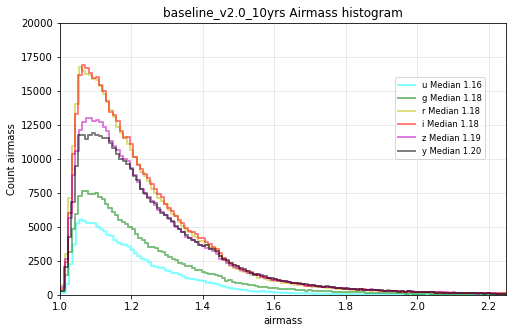

In [35]:
# Visualize the range of airmasses 
ph = maf.PlotHandler(outDir='m5_metrics', thumbnail=False, figformat='pdf')
bl = [b[k] for k in b if 'airmass histogram' in k and 'all' not in k]
ph.setMetricBundles(bl)
plotDict = {'figsize': (8, 5), 
            'title': f'{runName} Airmass histogram', 
            'yMin': 0, 'yMax': 20000, 
            'xMin': 1, 'xMax': 2.25,
            'linewidth': 2,
           'legendloc': (0.75, 0.5)}
ph.plot(plotFunc=maf.OneDBinnedData(), plotDicts=plotDict)

#### Seeing ####
The median atmospheric contribution to the seeing (FWHM_500) is 0.72", which is what is used in the 'sim seeing update' above. 

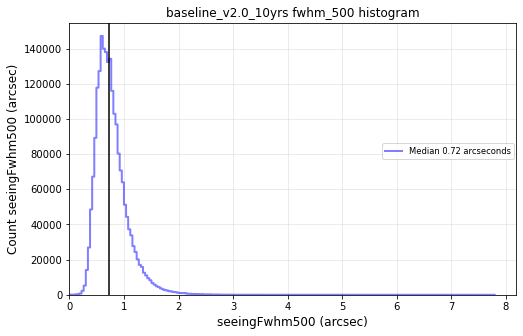

In [36]:
# Visualize the range of atmospheric seeing -- this should be close to the 'db_seeing' above, but may 
# slightly differ due to including or not including some of the database values (due to daytime, downtime, etc)
ph.setMetricBundles([b['fwhm_500 histogram']])
plotDict = {'figsize': (8, 5), 
            'title': f'{runName} fwhm_500 histogram', 
            'yMin': 0, 'xMin': 0,
            'linewidth': 2,
           'label': f"Median {b['median fwhm_500'].metricValues[0]:.2f} arcseconds",
           'legendloc': (0.7, 0.5),
           'fontsize': 'large'}
ph.plot(plotFunc=maf.OneDBinnedData(), plotDicts=plotDict)
plt.axvline(b['median fwhm_500'].metricValues[0], color='k')

The delivered seeing depends on the bandpass, as well as the airmass, in which a visit is acquired. It includes the telescope and dome contributions to the atmospheric seeing.

1

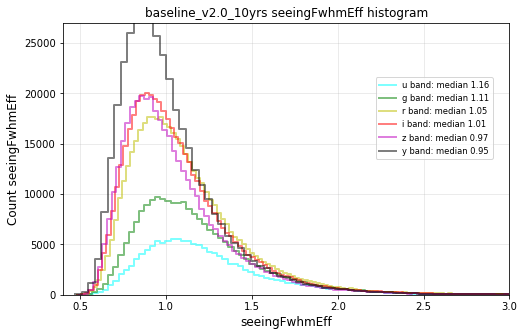

In [37]:
bundleList = []
plotList = []
for f in filterlist:
    bundleList.append(b[f'seeingFwhmEff histogram {f}'])
    key = f'median seeingFwhmEff {f}'
    plotList.append({'linewidth': 2, 
                     'legendloc': (0.7, 0.5), 
                     'figsize': (8, 5),
                     'title': f'{runName} seeingFwhmEff histogram', 
                    'label': f'{f} band: median {b[key].metricValues[0]:.2f}'})
ph.setMetricBundles(bundleList)
plotDict = {'yMin': 0, 'yMax':27000, 
            'xMin': 0.4, 'xMax': 3,
           'fontsize': 'large'}
plotList[-1].update(plotDict)
ph.plot(plotFunc=maf.OneDBinnedData(), plotDicts=plotList)

In [38]:
# We can compare these per-band median seeing values from the simulation
# with the expected seeing per-band from the median fwhm500 at X=1.2
# We see they are pretty close, so we're distributing visits in seeing and airmass fairly well between filters
predicted_median_x1 = seeing_model(b['median fwhm_500'].metricValues[0], 1.0)['fwhmEff']
predicted_median = seeing_model(b['median fwhm_500'].metricValues[0], 1.2)['fwhmEff']
simulated_median_seeing = []
for f in filterlist:
    simulated_median_seeing.append(b[f'median seeingFwhmEff {f}'].metricValues[0])

print('median fwhm_500', b['median fwhm_500'].metricValues[0])
d = pd.DataFrame([predicted_median_x1, predicted_median, simulated_median_seeing], 
             index=['Predicted median fwhm X=1.0', 'Predicted median fwhmEff (X=1.2)', 'Simulated median fwhmEff'],
             columns=filterlist)
d

median fwhm_500 0.7209119196896396


u      g      r      i      z      y
Predicted median fwhm X=1.0       1.044  0.979  0.923  0.884  0.858  0.837
Predicted median fwhmEff (X=1.2)  1.164  1.093  1.029  0.987  0.957  0.934
Simulated median fwhmEff          1.159  1.108  1.046  1.006  0.975  0.954

#### Skybrightness ####
Along with airmass and seeing, the actual range of skybrightness is also important for single visit m5 depth. 
Bluer bands are generally acquired near new moon, thus 'dark sky' values are approximately correct. Redder bands, however, tend to be acquired either during twilight or during bright time, thus the dark sky values do not match well. 

1

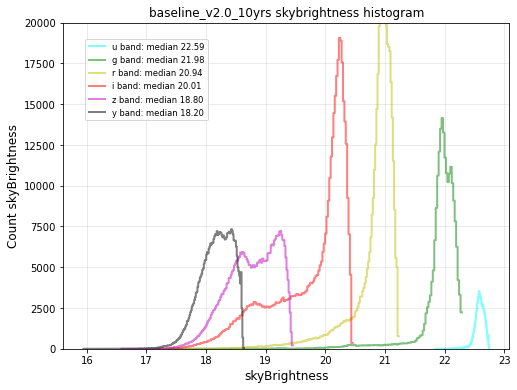

In [39]:
bundleList = []
plotList = []
for f in filterlist:
    bundleList.append(b[f'skybrightness histogram {f}'])
    key = f'median skybrightness {f}'
    plotList.append({'figsize': (8, 6), 'fontsize': 'large',
                     'linewidth': 2, 'legendloc': (0.05, 0.7),
                     'title': f'{runName} skybrightness histogram', 
                     'label': f'{f} band: median {b[key].metricValues[0]:.2f}'})
ph.setMetricBundles(bundleList)
plotDict = {'yMin': 0, 'yMax':20000}
plotList[-1].update(plotDict)
ph.plot(plotFunc=maf.OneDBinnedData(), plotDicts=plotList)

In [40]:
# and of course these per-band skybrightness values cover a wider range than the dark-sky values
simulated_median_skybrightness = {}
for f in filterlist:
    simulated_median_skybrightness[f] = b[f'median skybrightness {f}'].metricValues[0]

pd.DataFrame([dark_sky, simulated_median_skybrightness], 
             index=['Dark sky skybrightness', 'Simulated median skybrightness'],
             columns=filterlist).round(2)

u      g      r      i      z      y
Dark sky skybrightness          22.68  22.11  21.11  20.39  19.43  18.63
Simulated median skybrightness  22.59  21.98  20.94  20.01  18.80  18.20

#### Individual image m5 ####

Look at the distribution of individual image m 5 values.

1

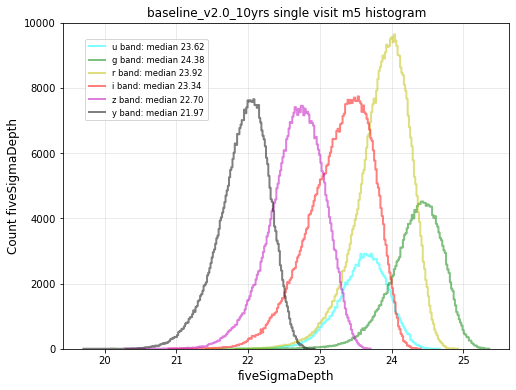

In [41]:
bundleList = []
plotList = []
for f in filterlist:
    bundleList.append(b[f'm5 histogram {f}'])
    key = f'median m5 {f}'
    plotList.append({'figsize': (8, 6), 'fontsize': 'large',
                     'linewidth': 2, 'legendloc': (0.05, 0.7),
                     'title': f'{runName} single visit m5 histogram', 
                     'label': f'{f} band: median {b[key].metricValues[0]:.2f}'})
ph.setMetricBundles(bundleList)
plotDict = {'yMin': 0, 'yMax':10000}
plotList[-1].update(plotDict)
ph.plot(plotFunc=maf.OneDBinnedData(), plotDicts=plotList)

In [42]:
m5['sim median'] = {}
for f in filterlist:
    m5['sim median'][f] = b[f"median m5 {f}"].metricValues[0]
    
pd.DataFrame(m5).T.round(2)

u      g      r      i      z      y
srd min                      23.40  24.60  24.30  23.60  22.90  21.70
srd                          23.90  25.00  24.70  24.00  23.30  22.10
srd system                   24.23  25.08  24.58  24.15  23.58  22.70
system with updated PSF      24.09  24.95  24.47  24.04  23.47  22.58
system with updated seeing   23.90  24.77  24.29  23.86  23.28  22.39
system with updated darksky  24.22  25.10  24.63  24.21  23.60  22.79
srd system with losses       24.02  24.94  24.46  24.03  23.46  22.59
30s uband system             24.38  25.10  24.63  24.21  23.60  22.79
sim reference                23.87  24.64  24.21  23.79  23.18  22.37
cadence reference            23.86  24.63  24.21  23.79  23.18  22.37
sim median                   23.62  24.38  23.92  23.34  22.70  21.97

### Impact of these distributions of simulated conditions ###

Using the same scaling relationship we use in the cadence simulation to calculate m5 from Cm + conditions, we can evaluate the impact of each of these contributions 'separately' (even though they are not entirely independent in reality, as increasing airmass will increase both seeing and skybrightness). 


In [62]:
## Set up table 3

d = {}
dmag_sim = {}
k1 = ['25th percentile', 'median', '75th percentile']
k2 = ['airmass', 'skybrightness', 'seeingFwhmEff']
for kk in k2:
    if kk == 'airmass':
        d['airmass ref'] = {}
        for f in filterlist:
            d['airmass ref'][f] = 1.0
    if kk == 'skybrightness':
        d['skybrightness ref'] = {}
        for f in filterlist:
            d['skybrightness ref'][f] = dark_sky[f]
    if kk == 'seeingFwhmEff':
        d['seeingFwhmEff ref'] = {}
        for f in filterlist:
            d['seeingFwhmEff ref'][f] = seeing_sim[f]
    for ki in k1:
        n = ' '.join([kk, ki])
        d[n] = {}
        for f in filterlist:
            d[n][f] = b[f'{ki} {kk} {f}'].metricValues[0]
for kk in k2:
    for ki in k1:
        n = ' '.join([kk, ki])
        dmag_sim[f'dmag {n}'] = {}
        for f in filterlist:            
            dmag_sim[f'dmag {n}'][f] = calc_dmag(kk, d[n][f], d[f'{kk} ref'][f], kAtm=kAtm[f])

dmag_sim['dmag median combined'] = {}
for f in filterlist:
    dmag_sim['dmag median combined'][f] = 0
    for kk in k2:
        dmag_sim['dmag median combined'][f] += dmag_sim[f'dmag {kk} median'][f]
        
d = pd.DataFrame(d).T
dmag_sim = (pd.DataFrame(dmag_sim).T
            .append(pd.DataFrame(m5['sim reference'], index=['m5 sim reference']))
            .append(pd.DataFrame(m5['sim median'], index=['m5 sim median'])))

display(d.round(2))
display(dmag_sim.round(2))
print(d.round(2).to_latex())
print(dmag_sim.round(2).to_latex())

u      g      r      i      z      y
airmass ref                     1.00   1.00   1.00   1.00   1.00   1.00
airmass 25th percentile         1.09   1.10   1.10   1.10   1.11   1.11
airmass median                  1.16   1.18   1.18   1.18   1.19   1.20
airmass 75th percentile         1.27   1.31   1.31   1.32   1.33   1.34
skybrightness ref              22.68  22.11  21.11  20.39  19.43  18.63
skybrightness 25th percentile  22.54  21.87  20.78  19.33  18.48  17.99
skybrightness median           22.59  21.98  20.94  20.01  18.80  18.20
skybrightness 75th percentile  22.64  22.10  21.03  20.23  19.13  18.39
seeingFwhmEff ref               1.04   0.98   0.92   0.88   0.86   0.84
seeingFwhmEff 25th percentile   0.97   0.93   0.88   0.85   0.83   0.82
seeingFwhmEff median            1.16   1.11   1.05   1.01   0.97   0.95
seeingFwhmEff 75th percentile   1.41   1.34   1.27   1.22   1.18   1.14

u      g      r      i      z      y
dmag airmass 25th percentile         0.05   0.02   0.01   0.01   0.01   0.02
dmag airmass median                  0.08   0.04   0.02   0.02   0.01   0.03
dmag airmass 75th percentile         0.13   0.07   0.04   0.03   0.02   0.06
dmag skybrightness 25th percentile   0.07   0.12   0.17   0.53   0.48   0.32
dmag skybrightness median            0.04   0.07   0.09   0.19   0.31   0.22
dmag skybrightness 75th percentile   0.02   0.01   0.04   0.08   0.15   0.12
dmag seeingFwhmEff 25th percentile  -0.08  -0.05  -0.05  -0.04  -0.03  -0.03
dmag seeingFwhmEff median            0.12   0.14   0.14   0.14   0.14   0.14
dmag seeingFwhmEff 75th percentile   0.33   0.35   0.34   0.35   0.35   0.34
dmag median combined                 0.24   0.24   0.25   0.35   0.47   0.39
m5 sim reference                    23.87  24.64  24.21  23.79  23.18  22.37
m5 sim median                       23.62  24.38  23.92  23.34  22.70  21.97

\begin{tabular}{lrrrrrr}
\toprule
{} &      u &      g &      r &      i &      z &      y \\
\midrule
airmass ref                   &   1.00 &   1.00 &   1.00 &   1.00 &   1.00 &   1.00 \\
airmass 25th percentile       &   1.09 &   1.10 &   1.10 &   1.10 &   1.11 &   1.11 \\
airmass median                &   1.16 &   1.18 &   1.18 &   1.18 &   1.19 &   1.20 \\
airmass 75th percentile       &   1.27 &   1.31 &   1.31 &   1.32 &   1.33 &   1.34 \\
skybrightness ref             &  22.68 &  22.11 &  21.11 &  20.39 &  19.43 &  18.63 \\
skybrightness 25th percentile &  22.54 &  21.87 &  20.78 &  19.33 &  18.48 &  17.99 \\
skybrightness median          &  22.59 &  21.98 &  20.94 &  20.01 &  18.80 &  18.20 \\
skybrightness 75th percentile &  22.64 &  22.10 &  21.03 &  20.23 &  19.13 &  18.39 \\
seeingFwhmEff ref             &   1.04 &   0.98 &   0.92 &   0.88 &   0.86 &   0.84 \\
seeingFwhmEff 25th percentile &   0.97 &   0.93 &   0.88 &   0.85 &   0.83 &   0.82 \\
seeingFwhmEff median       

In [69]:
pd.DataFrame([dmag_sim.loc['m5 sim reference'] - dmag_sim.loc['m5 sim median'], 
              dmag_sim.loc['dmag median combined']],
            index=['difference m5 (ref-median)', 'dmag median combined'])

u      g      r      i      z      y
difference m5 (ref-median)  0.248  0.262  0.287  0.448  0.482  0.402
dmag median combined        0.241  0.240  0.247  0.346  0.466  0.393

The median simulation m5 depth tends to be shallower than the combination of the median values, most noticeably for g, r and i bands. Looking at the histogram of the m5 depths for these bands below, it seems that these bands in particular are distributed with a bit of skew and less gaussian. 

1

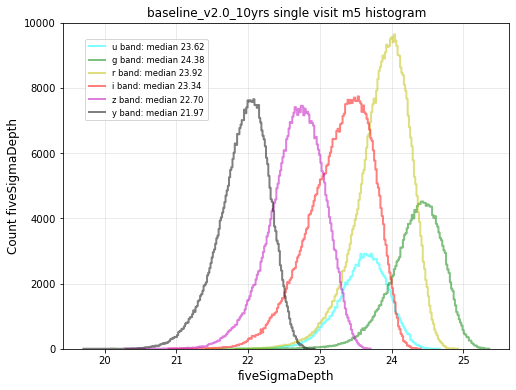

In [45]:
bundleList = []
plotList = []
for f in filterlist:
    bundleList.append(b[f'm5 histogram {f}'])
    key = f'median m5 {f}'
    plotList.append({'figsize': (8, 6), 'fontsize': 'large',
                     'linewidth': 2, 'legendloc': (0.05, 0.7),
                     'title': f'{runName} single visit m5 histogram', 
                     'label': f'{f} band: median {b[key].metricValues[0]:.2f}'})
ph.setMetricBundles(bundleList)
plotDict = {'yMin': 0, 'yMax':10000}
plotList[-1].update(plotDict)
ph.plot(plotFunc=maf.OneDBinnedData(), plotDicts=plotList)

The "typical" values of airmass, seeing, and skybrightness result in changes in the single visit limiting magnitude which correspond reasonably well to the median individual visit depths from the simulation. We can then trace the changes in limiting magnitude according to conditions; note that Cm has been constant throughout all of the simulation evaluation.

In [71]:
d = pd.DataFrame(m5)

In [72]:
d.add_prefix('m5 ').round(2)

m5 srd min  m5 srd  m5 srd system  m5 system with updated PSF  \
u        23.4    23.9          24.23                       24.09   
g        24.6    25.0          25.08                       24.95   
r        24.3    24.7          24.58                       24.47   
i        23.6    24.0          24.15                       24.04   
z        22.9    23.3          23.58                       23.47   
y        21.7    22.1          22.70                       22.58   

   m5 system with updated seeing  m5 system with updated darksky  \
u                          23.90                           24.22   
g                          24.77                           25.10   
r                          24.29                           24.63   
i                          23.86                           24.21   
z                          23.28                           23.60   
y                          22.39                           22.79   

   m5 srd system with losses  m5 30s uband system  m5 sim reference  \
u                      24.02                24.38             23.87   
g                      24.94                25.10             24.64   
r                      24.46                24.63             24.21   
i                      24.03                24.21             23.79   
z                      23.46                23.60             23.18   
y                      22.59                22.79             22.37   

   m5 cadence reference  m5 sim median  
u                 23.86          23.62  
g                 24.63          24.38  
r                 24.21          23.92  
i                 23.79          23.34  
z                 23.18          22.70  
y                 22.37          21.97

In [74]:
d.subtract(d['sim reference'], axis=0).add_prefix('m5 ').round(2)

m5 srd min  m5 srd  m5 srd system  m5 system with updated PSF  \
u       -0.47    0.03           0.36                        0.22   
g       -0.04    0.36           0.44                        0.31   
r        0.09    0.49           0.37                        0.26   
i       -0.19    0.21           0.36                        0.25   
z       -0.28    0.12           0.40                        0.28   
y       -0.67   -0.27           0.33                        0.20   

   m5 system with updated seeing  m5 system with updated darksky  \
u                           0.03                            0.35   
g                           0.12                            0.45   
r                           0.07                            0.42   
i                           0.07                            0.42   
z                           0.10                            0.41   
y                           0.02                            0.42   

   m5 srd system with losses  m5 30s uband system  m5 sim reference  \
u                       0.15                 0.51               0.0   
g                       0.30                 0.45               0.0   
r                       0.25                 0.42               0.0   
i                       0.24                 0.42               0.0   
z                       0.28                 0.41               0.0   
y                       0.21                 0.42               0.0   

   m5 cadence reference  m5 sim median  
u                 -0.01          -0.25  
g                 -0.01          -0.26  
r                 -0.00          -0.29  
i                 -0.00          -0.45  
z                 -0.00          -0.48  
y                 -0.00          -0.40

In [77]:
pd.DataFrame(dmag_system).round(2).T

u     g     r     i     z     y
psf update            0.14  0.13  0.11  0.11  0.11  0.12
fwhm500 update        0.19  0.19  0.18  0.18  0.18  0.18
dark sky update       0.01 -0.02 -0.05 -0.05 -0.02 -0.09
contamination losses  0.21  0.14  0.12  0.12  0.12  0.11
30s uband system     -0.16  0.00  0.00  0.00  0.00  0.00
combined              0.38  0.44  0.37  0.36  0.40  0.33

In [79]:
dmag_sim.round(2)

u      g      r      i      z      y
dmag airmass 25th percentile         0.05   0.02   0.01   0.01   0.01   0.02
dmag airmass median                  0.08   0.04   0.02   0.02   0.01   0.03
dmag airmass 75th percentile         0.13   0.07   0.04   0.03   0.02   0.06
dmag skybrightness 25th percentile   0.07   0.12   0.17   0.53   0.48   0.32
dmag skybrightness median            0.04   0.07   0.09   0.19   0.31   0.22
dmag skybrightness 75th percentile   0.02   0.01   0.04   0.08   0.15   0.12
dmag seeingFwhmEff 25th percentile  -0.08  -0.05  -0.05  -0.04  -0.03  -0.03
dmag seeingFwhmEff median            0.12   0.14   0.14   0.14   0.14   0.14
dmag seeingFwhmEff 75th percentile   0.33   0.35   0.34   0.35   0.35   0.34
dmag median combined                 0.24   0.24   0.25   0.35   0.47   0.39
m5 sim reference                    23.87  24.64  24.21  23.79  23.18  22.37
m5 sim median                       23.62  24.38  23.92  23.34  22.70  21.97

The final m5 values do fall below SRD m5 single visit expectations, but this is due to 
* evolving understanding of the delivered seeing (FWHM_500 was 0.6" for the SRD but included a smaller contribution from the hardware system and was a simpler PSF profile). This is an impact of between 0.14-0.11 mag.
* evolving understanding of the expected atmospheric contribution from FWHM500 from the atmosphere - this changed from 0.6" to 0.72" with a longer time baseline. This is an impact of about 0.19 mag. 
* contamination losses over the lifetime of the survey contribute between 0.1 to 0.2 mag
* observing in a range of skybrightness conditions throughout the lunar cycle. This has an impact of between 0.3 to 0.03 magnitudes, depending on bandpass. The redder bands suffer larger losses, but also have higher throughputs compared to the SRD. This is generally unavoidable, as dark time must be used for the bluer bandpasses where sky brightness variations are larger.
* observing at a range of airmasses, with a median of X=1.2. This has an impact of between 0.1 to 0.01 magnitudes, depending on bandpass.  This is a minimal impact for the overall gain of survey flexibility, longer seasonal availability, and better parallax determination. Note that future survey choices may make larger impacts here, if observations are driven to higher airmass.
* observing at a range of airmasses impacts the delivered seeing, with an impact of between 0.12-0.14 magnitudes

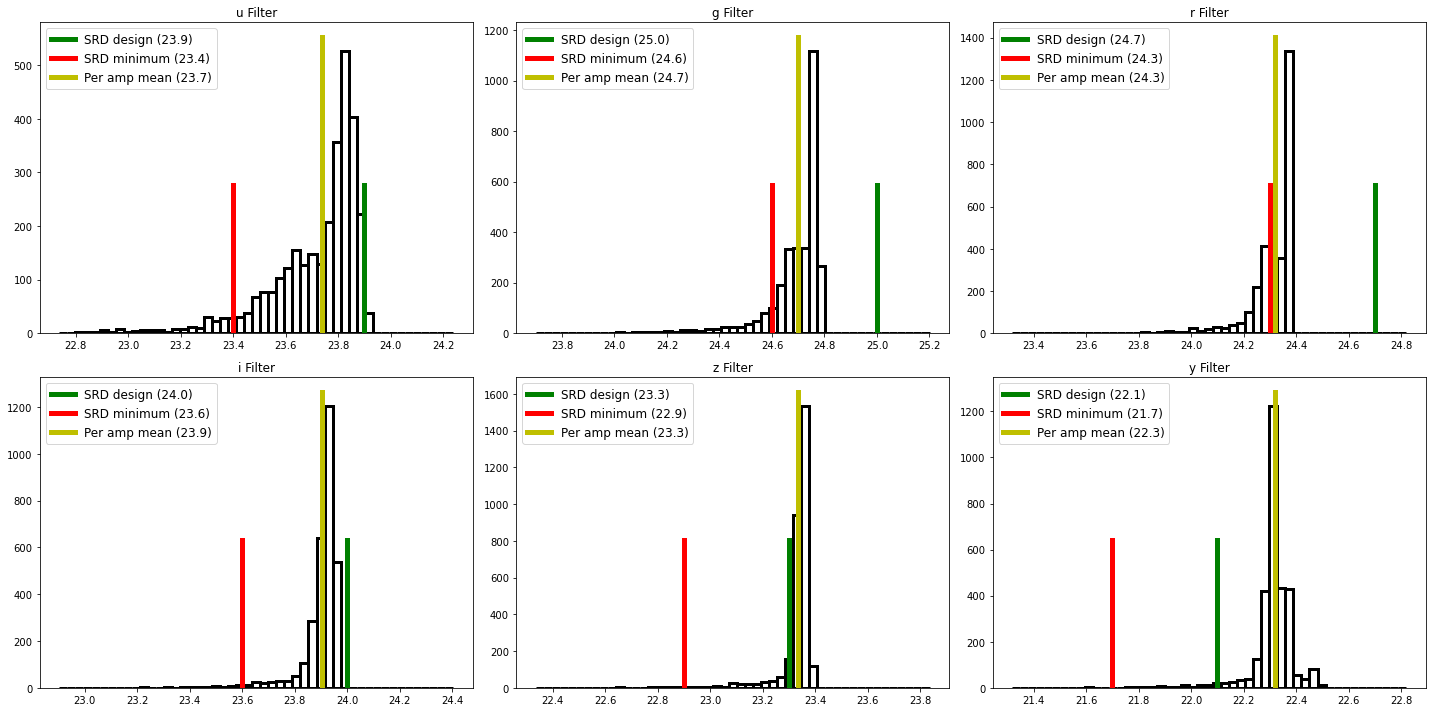

In [80]:
# Per amp calculations (done in separate script, saved to output file)
from ast import literal_eval

def get_m5all(f):
    '''
    f is filter, can be u,g,r,i,z,y
    '''
    m5all = []
    m5vals = pd.read_csv('/Users/lynnej/other_repos/f_factors/source/m5_by_amp/m5_output/m5df_13040.csv', index_col=0)
    for key in m5vals:
        res = m5vals[key].apply(literal_eval)[f]
        for res1 in res:
            m5all.append(res1)
    #print('%s band, found %.0f rafts'%(f, len(m5all)/16/9))
    while -1 in m5all:
        #get rid of the dead channels, we account for them in fF.
        m5all.remove(-1)
    #print(sum([1 if ele<0 else 0 for ele in m5all]))
    return m5all

filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
fig, ax = plt.subplots(2,3,figsize=(20,5*2))

m5_amp = {}
mean_m5_amp = {}
Cm_amp = {}
mean_Cm_amp = {}
for i,f in enumerate(filterlist):
    irow = np.int8(i/3)
    icol = np.mod(i,3)
    if f == 'u':
        m5_amp[f] = np.array(get_m5all('u_30'))
    else:
        m5_amp[f] = np.array(get_m5all(f))
    Cm_amp[f], jj = calcCm(m5_amp[f], skyMag[f], fid_fwhmEff[f], kAtm[f], X=1.0)
    #SRD Table 7.
    mm5 = np.log10(np.mean(10**(0.8*(m5_amp[f]))))/0.8
    mean_m5_amp[f] = mm5
    cm5 = np.log10(np.mean(10**(0.8*(Cm_amp[f]))))/0.8
    mean_Cm_amp[f] = cm5
    #break
    binlow = mm5-1
    binhigh = binlow+1.5
    bins = np.linspace(binlow, binhigh,50)
    ax[irow][icol].hist(m5_amp[f], bins, fill=False, linewidth=3)
    (y1, y2) = (ax[irow][icol].get_ylim())
    ax[irow][icol].plot([m5['srd'][f], m5['srd'][f]],[y1, y2/2], linewidth=5, color='g', 
                        label=f"SRD design ({m5['srd'][f]:.1f})")
    ax[irow][icol].plot([m5['srd min'][f], m5['srd min'][f]],[y1, y2/2], linewidth=5, color='r', 
                        label=f"SRD minimum ({m5['srd min'][f]:.1f})")
    #ax[irow][icol].plot([m52019[i], m52019[i]],[y1, y2], linewidth=5, color='b', label='Summer 2019')
    ax[irow][icol].plot([mm5, mm5],[y1, y2], linewidth=5, color='y', 
                        label=f'Per amp mean ({mm5:.1f})')
    #ax[irow][icol].text(0.85, 0.48, f, color = 'black', transform=ax[irow][icol].transAxes, fontsize=15)
    #ax[irow][icol].text(0.67, 0.28, '  design = %.1f\n       min = %.1f\naverage = %.1f'%(m5design[i], m5min[i], mm5), 
    #                    color = 'black', transform=ax[irow][icol].transAxes, fontsize=13)
    ax[irow][icol].legend(fancybox=True, numpoints=1, fontsize='large')
    ax[irow][icol].set_title(f'{f} Filter', fontsize='large')

plt.tight_layout()

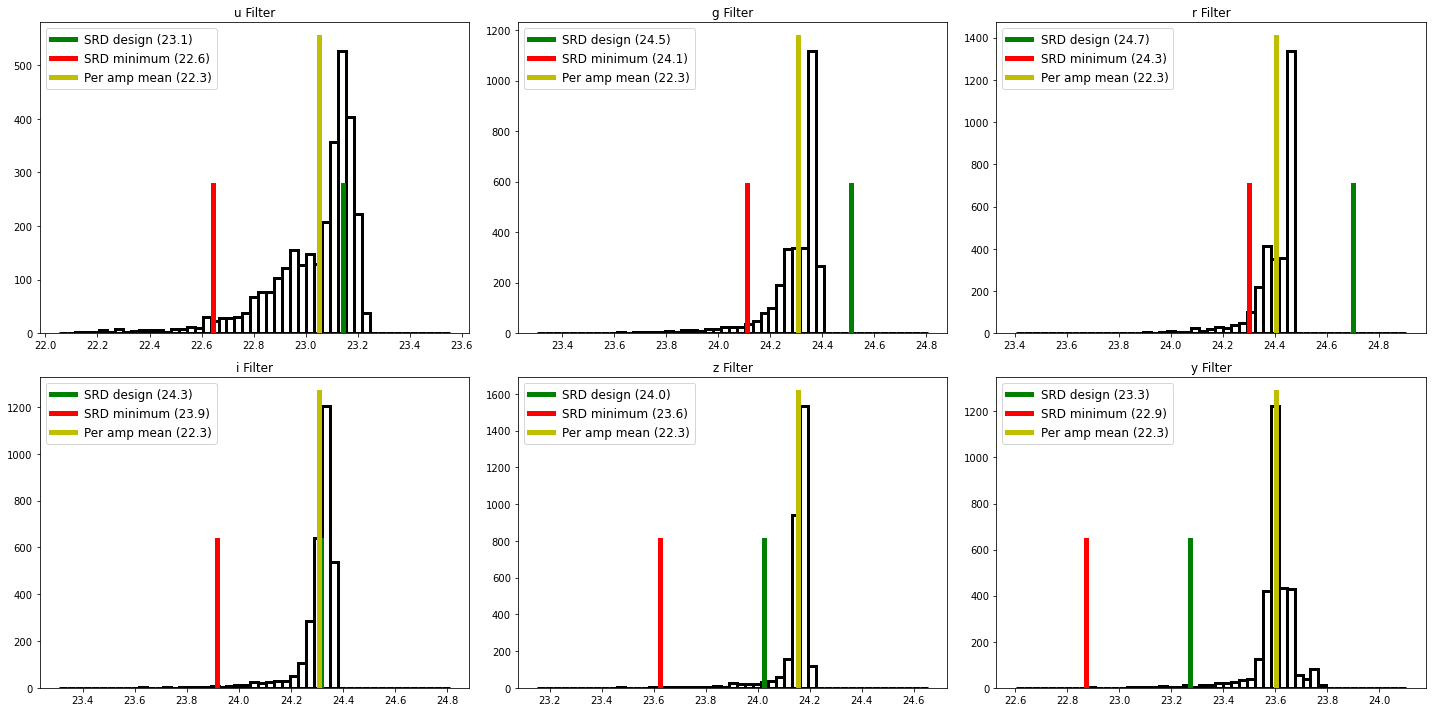

In [81]:
# Same plot - but with Cm not m5
fig, ax = plt.subplots(2,3,figsize=(20,5*2))
for i,f in enumerate(filterlist):
    irow = np.int8(i/3)
    icol = np.mod(i,3)

    cm5 = np.log10(np.mean(10**(0.8*(Cm_amp[f]))))/0.8
    #break
    binlow = cm5-1
    binhigh = binlow+1.5
    bins = np.linspace(binlow, binhigh,50)
    ax[irow][icol].hist(Cm_amp[f], bins, fill=False, linewidth=3)
    (y1, y2) = (ax[irow][icol].get_ylim())
    ax[irow][icol].plot([Cm['srd'][f], Cm['srd'][f]],[y1, y2/2], linewidth=5, color='g', 
                        label=f'SRD design ({Cm["srd"][f]:.1f})')
    ax[irow][icol].plot([Cm['srd min'][f], Cm['srd min'][f]],[y1, y2/2], linewidth=5, color='r', 
                        label=f'SRD minimum ({Cm["srd min"][f]:.1f})')
    #ax[irow][icol].plot([m52019[i], m52019[i]],[y1, y2], linewidth=5, color='b', label='Summer 2019')
    ax[irow][icol].plot([cm5, cm5],[y1, y2], linewidth=5, color='y', 
                        label=f'Per amp mean ({mm5:.1f})')
    #ax[irow][icol].text(0.85, 0.48, f, color = 'black', transform=ax[irow][icol].transAxes, fontsize=15)
    #ax[irow][icol].text(0.67, 0.28, '  design = %.1f\n       min = %.1f\naverage = %.1f'%(m5design[i], m5min[i], mm5), 
    #                    color = 'black', transform=ax[irow][icol].transAxes, fontsize=13)
    ax[irow][icol].legend(fancybox=True, numpoints=1, fontsize='large')
    ax[irow][icol].set_title(f'{f} Filter', fontsize='large')

plt.tight_layout()

In [83]:
# What is the effective readnoise, that recreates the mean Cm values and the mean m5 values from above?
# Have to consider that above values include vignetting, which in general we don't include
# as part of SRD comparison (?) nor MAF calculations (currently)


### Coadded depth ###

The single visit depth is the basis for the coadded m5 limits, however it also folds in the number of visits per pointing. (plus has some inclusion of 'tails' in the distribution)

In [84]:
for f in filterlist:
    for k in [f'Nvisits {f}', f'wfd Nvisits {f}', f'coadd m5 {f}', f'wfd coadd m5 {f}']:
        b[k].setPlotDict({'label': f"{f} median {b[k].summaryValues['Median']}",
                                   'xlabel': k})

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


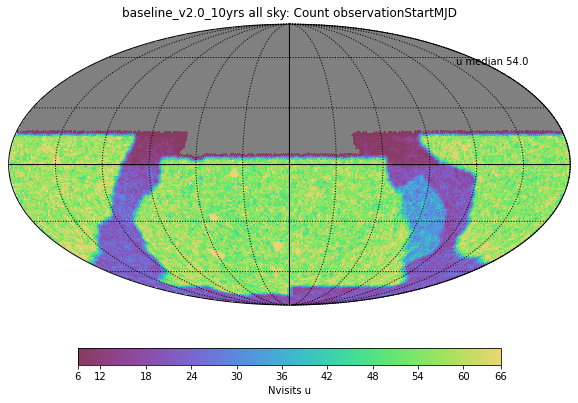

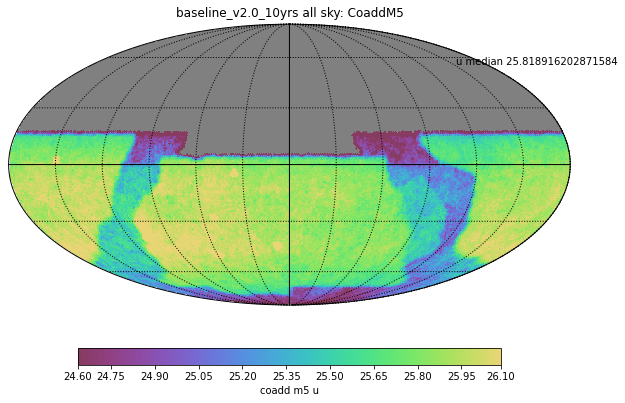

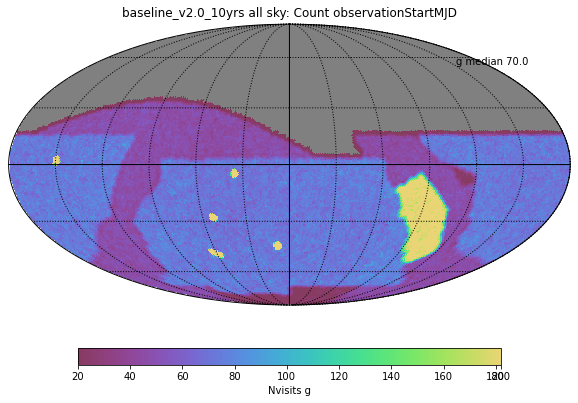

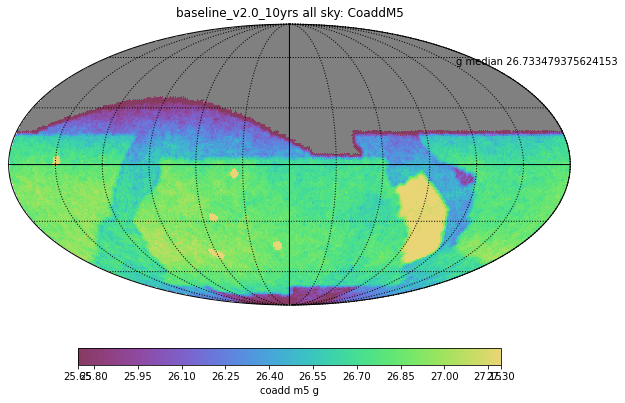

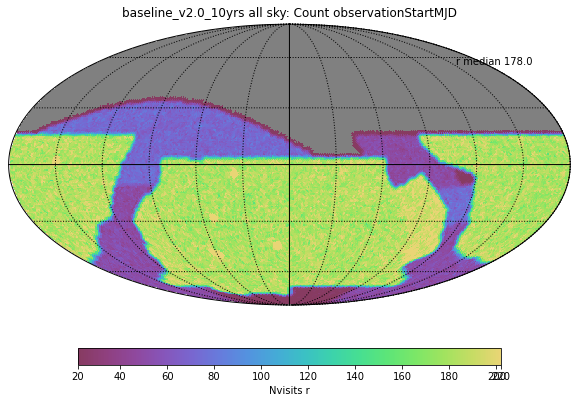

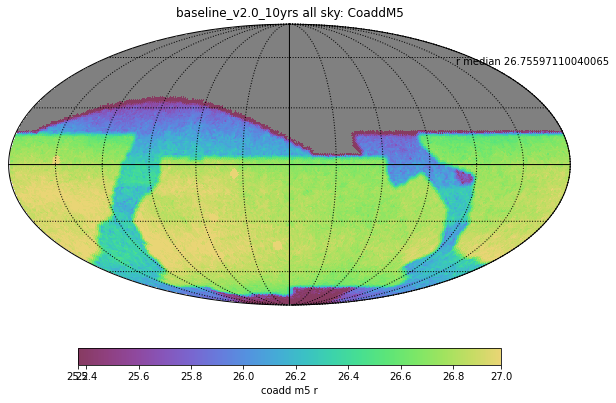

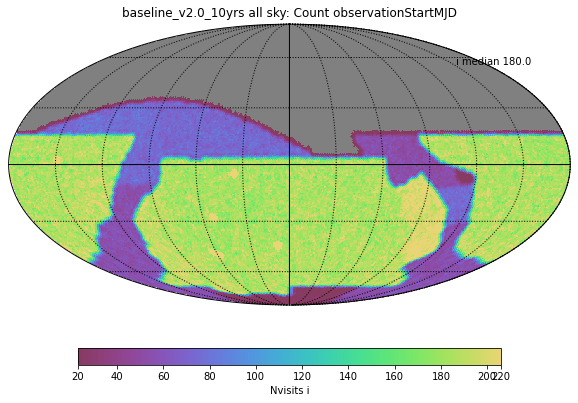

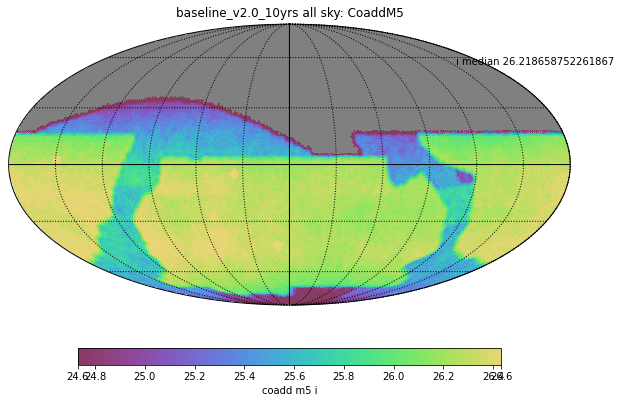

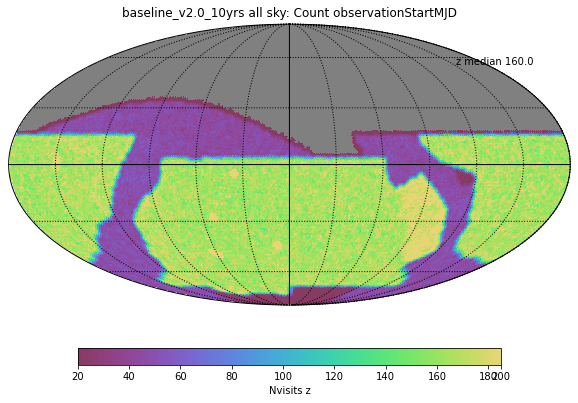

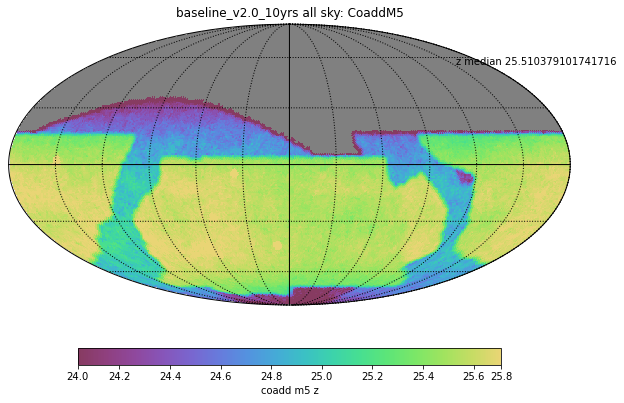

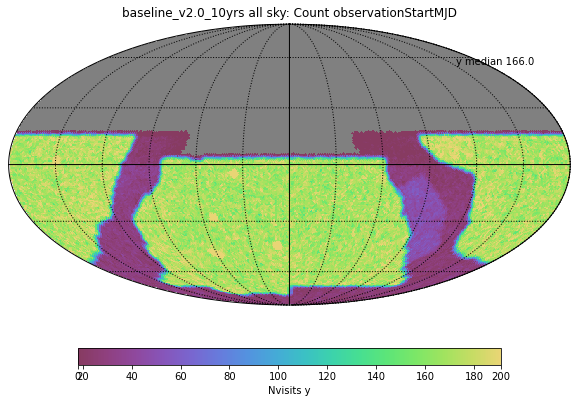

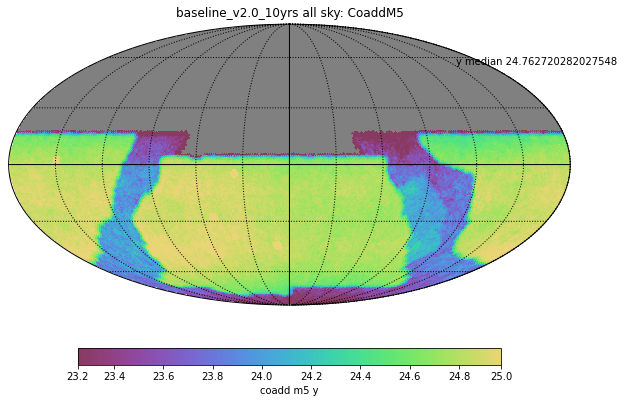

In [85]:
for f in filterlist:
    ph.setMetricBundles([b[f'Nvisits {f}']])
    ph.plot(plotFunc=maf.HealpixSkyMap(), plotDicts={'figsize': (8,6), 'percentileClip': 95})
    ph.setMetricBundles([b[f'coadd m5 {f}']])
    ph.plot(plotFunc=maf.HealpixSkyMap(), plotDicts={'figsize': (8,6), 'percentileClip': 95})

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


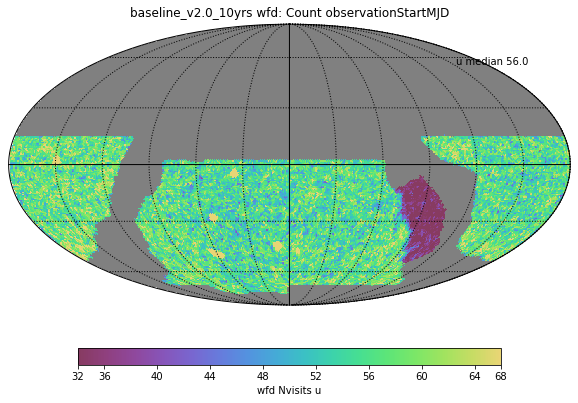

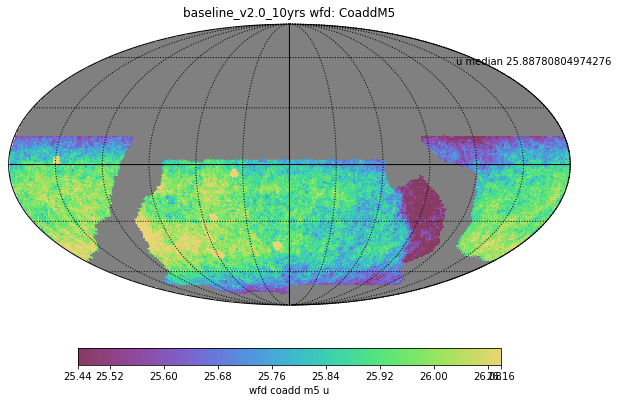

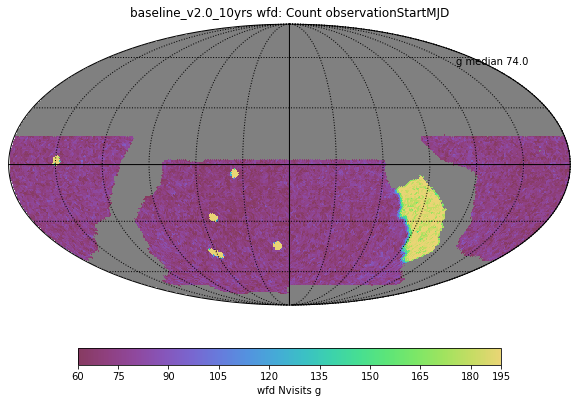

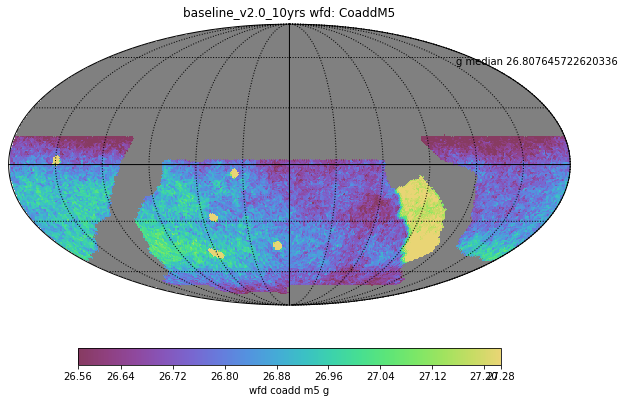

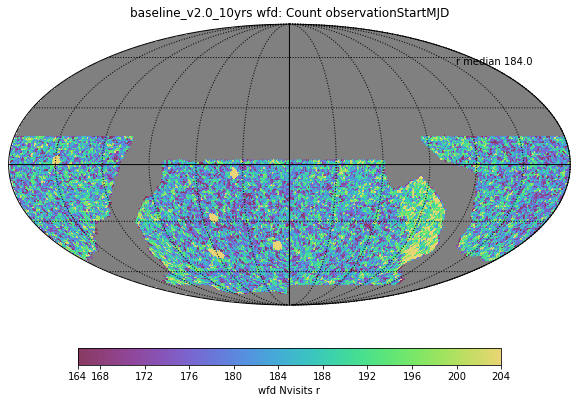

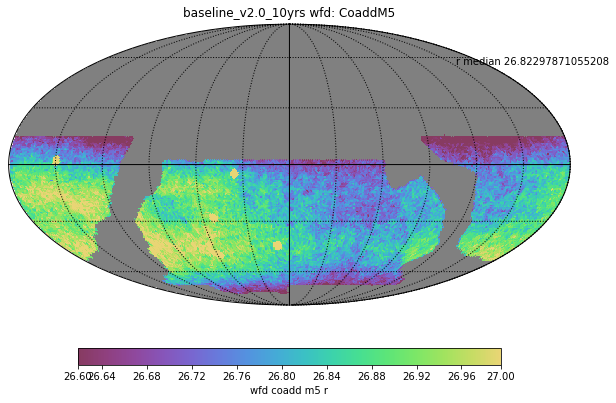

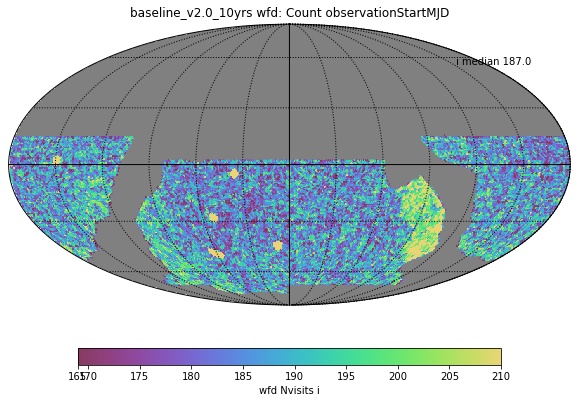

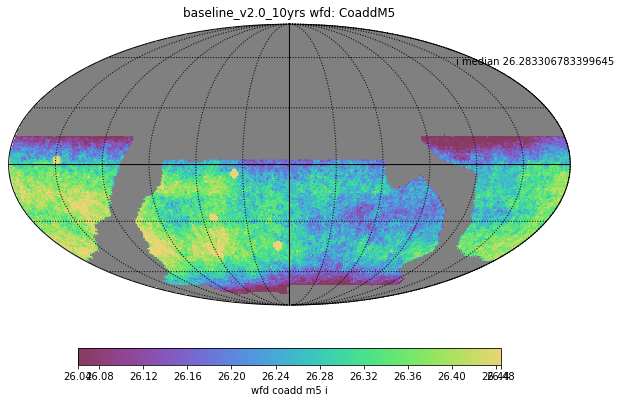

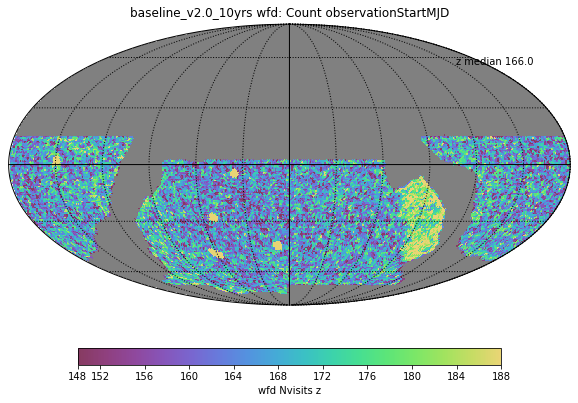

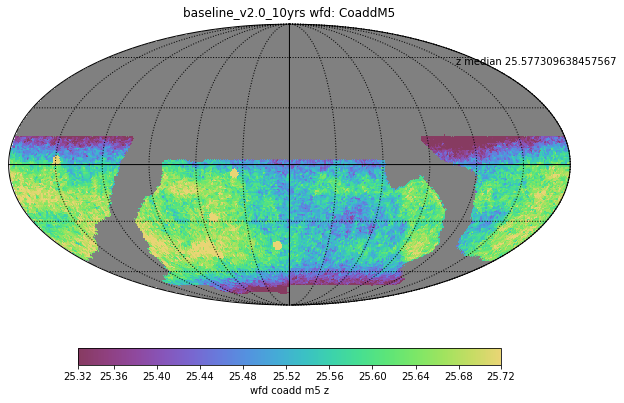

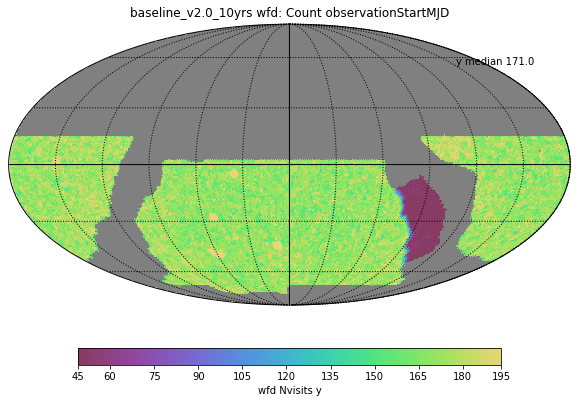

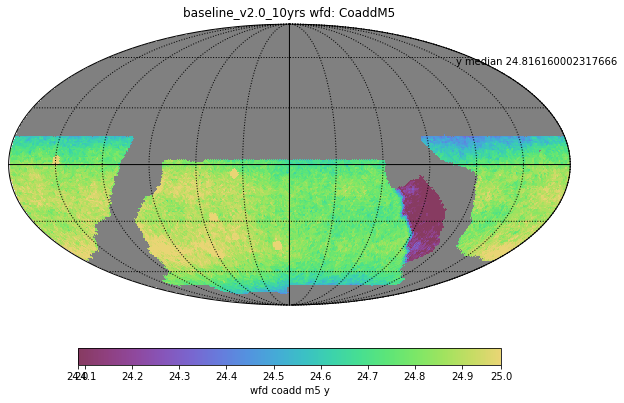

In [86]:
for f in filterlist:
    ph.setMetricBundles([b[f'wfd Nvisits {f}']])
    ph.plot(plotFunc=maf.HealpixSkyMap(), plotDicts={'figsize': (8,6), 'percentileClip': 95})
    ph.setMetricBundles([b[f'wfd coadd m5 {f}']])
    ph.plot(plotFunc=maf.HealpixSkyMap(), plotDicts={'figsize': (8,6), 'percentileClip': 95})

2

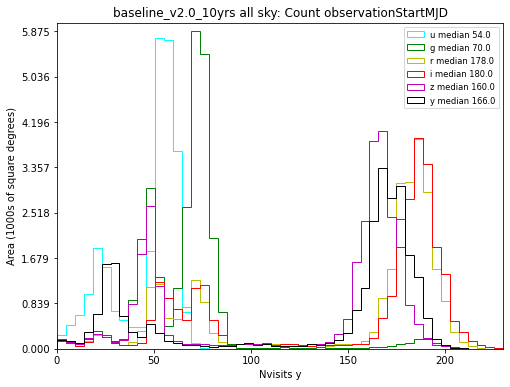

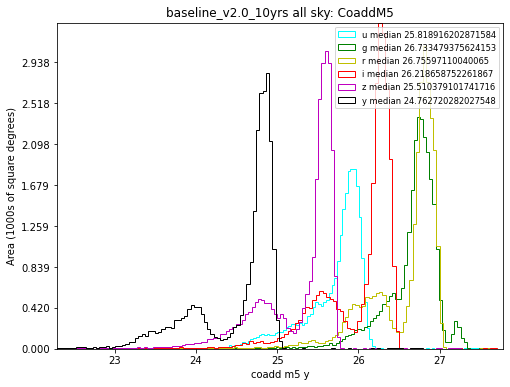

In [87]:
blNvis = [b[f'Nvisits {f}'] for f in filterlist]
blCoadd = [b[f'coadd m5 {f}'] for f in filterlist]
ph.setMetricBundles(blNvis)
ph.plot(plotFunc=maf.HealpixHistogram(), plotDicts={'figsize': (8,6), 'xMin': 0, 'xMax': 230, 'bins':50})
ph.setMetricBundles(blCoadd)
ph.plot(plotFunc=maf.HealpixHistogram(), plotDicts={'figsize': (8,6), 'bins': 150})

2

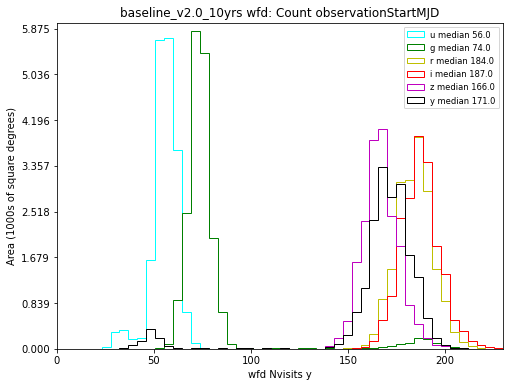

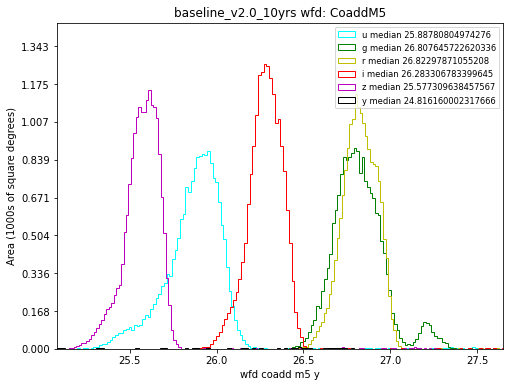

In [88]:
blNvis = [b[f'wfd Nvisits {f}'] for f in filterlist]
blCoadd = [b[f'wfd coadd m5 {f}'] for f in filterlist]
ph.setMetricBundles(blNvis)
ph.plot(plotFunc=maf.HealpixHistogram(), plotDicts={'figsize': (8,6), 'xMin': 0, 'xMax': 230, 'bins':50})
ph.setMetricBundles(blCoadd)
ph.plot(plotFunc=maf.HealpixHistogram(), plotDicts={'figsize': (8,6), 'bins': 150})

In [89]:
# In general, the medians for each of these metrics simply represents the WFD area, 
# as this is the overwhelming portion of the survey. 
nvisits = pd.DataFrame([b[f'wfd Nvisits {f}'].summaryValues['Median'] for f in filterlist], 
                       index=filterlist, columns=['Median Nvisits'])
nvis25 = pd.DataFrame([b[f'wfd Nvisits {f}'].summaryValues['25th%ile'] for f in filterlist], index=filterlist,
                     columns=['Nvisits 25th percentile'])
nvis75 = pd.DataFrame([b[f'wfd Nvisits {f}'].summaryValues['75th%ile'] for f in filterlist], index=filterlist,
                     columns=['Nvisits 75th percentile'])
coadd = pd.DataFrame([b[f'wfd coadd m5 {f}'].summaryValues['Median'] for f in filterlist], 
                     index=filterlist, columns=['Median Coadd m5'])
dd = pd.concat([nvis25.T, nvisits.T, nvis75.T, coadd.T])
display(dd)
print(dd.round(1).to_latex())

u       g        r        i        z        y
Nvisits 25th percentile  53.000  70.000  178.000  181.000  160.000  164.000
Median Nvisits           56.000  74.000  184.000  187.000  166.000  171.000
Nvisits 75th percentile  59.000  78.000  190.000  193.000  173.000  178.000
Median Coadd m5          25.888  26.808   26.823   26.283   25.577   24.816

\begin{tabular}{lrrrrrr}
\toprule
{} &     u &     g &      r &      i &      z &      y \\
\midrule
Nvisits 25th percentile &  53.0 &  70.0 &  178.0 &  181.0 &  160.0 &  164.0 \\
Median Nvisits          &  56.0 &  74.0 &  184.0 &  187.0 &  166.0 &  171.0 \\
Nvisits 75th percentile &  59.0 &  78.0 &  190.0 &  193.0 &  173.0 &  178.0 \\
Median Coadd m5         &  25.9 &  26.8 &   26.8 &   26.3 &   25.6 &   24.8 \\
\bottomrule
\end{tabular}



In [90]:
nvisits.sum()

Median Nvisits    838.0
dtype: float64

Calculate the fraction of time spent on "WFD" by defining WFD as the area with >750 visits per pointing, then identifying visits which overlap these healpixels by more than 40% as 'WFD visits' (if the visits overlaps by less than 0.4 then they will not be counted towards WFD visits). 

In [91]:
cols = ['observationStartMJD', 'fieldRA', 'fieldDec', 'rotSkyPos', 'note', 'visitExposureTime']
simdata = maf.getSimData(opsim_db_file, '', cols)

In [92]:
stacker = maf.WFDlabelStacker(np.where(wfd_footprint>0, 1, 0), fp_threshold=0.4, area_id_name='wfd')
simdata = stacker.run(simdata)

In [93]:
totalNvisits = len(simdata)
totalWFDvisits = len(simdata[np.where(simdata['areaId'] == 'wfd')])
fraction_wfd = totalWFDvisits/totalNvisits
print(f'Out of {totalNvisits} total visits, {totalWFDvisits} contributed to WFD coverage.')
print(f'A fraction of {fraction_wfd*100:.1f}%.')

Out of 2086980 total visits, 1732972 contributed to WFD coverage.
A fraction of 83.0%.


In [94]:
fOsummaries = [maf.fONv(Asky=18000.0, nside=64, Nvisit=750, norm=True),
               maf.fOArea(Asky=18000.0, nside=64, Nvisit=750, norm=True)]
metric = maf.CountExplimMetric(col='observationStartMJD', metricName="fO", expCol='visitExposureTime')
slicer = maf.HealpixSlicer(nside=64)
fObundle = maf.MetricBundle(metric, slicer, '', runName=runName, summaryMetrics=fOsummaries)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [95]:
g = maf.MetricBundleGroup({'fO': fObundle}, opsim_db_file, 'm5_metrics', None)
g.runCurrent('', simData=simdata)

Running:  ['fO']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [96]:
median_nvis_18k = fObundle.summaryValues['fONv'][0][-1]
minimum_nvis_18k = fObundle.summaryValues['fONv'][1][-1]
area_with_750visits = fObundle.summaryValues['fOArea']
print(f'The median number of visits per pointing, in the top 18,0000 sq degrees is {median_nvis_18k*750}.')
print(f'The minimum number of visits per pointing, in the top 18,0000 sq degrees is {minimum_nvis_18k*750}.')
print(f'The area on sky with at least 750 visits per pointing is {area_with_750visits*18000} sq degrees.')

The median number of visits per pointing, in the top 18,0000 sq degrees is 839.0.
The minimum number of visits per pointing, in the top 18,0000 sq degrees is 786.9999999999999.
The area on sky with at least 750 visits per pointing is 18620.568812654947 sq degrees.


As the SRD is worded, the requirement is to cover at least 18,000 sq degrees with a median of at least 750 (minimum) or 825 (design) visits per pointing. This comes closest to the `median_nvis_18k` above, and over this 18,000 sq degrees we reach a median number of visits per pointing > 825.

In [97]:
print('Potentially, we could direct all non-WFD visits into WFD area as "reserve".')
print(f'This implies we have a "reserve" of {median_nvis_18k / fraction_wfd} on the ' \
      'median number of visits per pointing over 18k sq degrees above.')

Potentially, we could direct all non-WFD visits into WFD area as "reserve".
This implies we have a "reserve" of 1.3471856210025321 on the median number of visits per pointing over 18k sq degrees above.


In [98]:
print('Potentially, we could direct all non-WFD visits into WFD area as "reserve".')
print(f'This implies we have a "reserve" of {minimum_nvis_18k / fraction_wfd} on the ' \
      'minimum number of visits per pointing over 18k sq degrees above.')

Potentially, we could direct all non-WFD visits into WFD area as "reserve".
This implies we have a "reserve" of 1.2636890151716242 on the minimum number of visits per pointing over 18k sq degrees above.


u band deltaM5 in final 10% (7 visits): 0.06 mag
u band deltaM5 in final 20 visits (0.25316455696202533%): 0.16 mag
g band deltaM5 in final 10% (9 visits): 0.06 mag
g band deltaM5 in final 20 visits (0.20202020202020202%): 0.12 mag
r band deltaM5 in final 10% (17 visits): 0.06 mag
r band deltaM5 in final 20 visits (0.11173184357541899%): 0.06 mag
i band deltaM5 in final 10% (17 visits): 0.06 mag
i band deltaM5 in final 20 visits (0.11173184357541899%): 0.06 mag
z band deltaM5 in final 10% (19 visits): 0.06 mag
z band deltaM5 in final 20 visits (0.10050251256281408%): 0.06 mag
y band deltaM5 in final 10% (19 visits): 0.06 mag
y band deltaM5 in final 20 visits (0.10050251256281408%): 0.06 mag


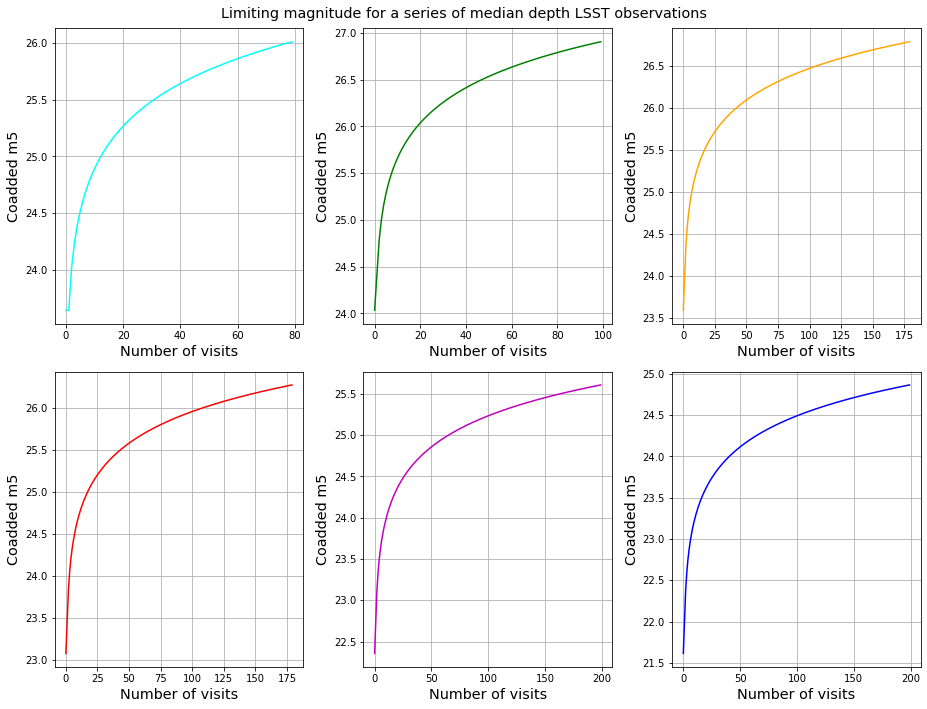

In [99]:
# Growth of coadded depth with number of visits - separate per band so they have their own scale\
# Assume each visit is the median single visit depth

expTime = {}
nexp = {}
for f in filterlist:
    expTime[f] = 15
    nexp[f] = 2
expTime['u'] = 30
nexp['u'] = 1
nvisits_max = {'u': 80, 'g': 100, 'r': 180, 'i': 180, 'z': 200, 'y': 200}
plt.figure(figsize=(13, 10))
j=1
for f in ('u', 'g', 'r', 'i', 'z', 'y'):
    plt.subplot(2,3,j)
    nvisitrange = np.arange(0, nvisits_max[f], 1)
    m5_t = np.zeros(len(nvisitrange), float)
    for i, nvis in enumerate(nvisitrange):
        m5_t[i] = rsUtils.m5_flat_sed(f, simulated_median_skybrightness[f],
                              b[f'median seeingFwhmEff {f}'].metricValues[0],
                              expTime[f],
                              airmass=b[f'median airmass {f}'].metricValues[0],
                              nexp=nvis*nexp[f])
    # last 10% of total visits gains what depth?
    i = nvisits_max[f]-10
    last10percent = int(0.9*i)
    dm5_final = m5_t[i] - m5_t[last10percent]
    label = f'{f} band deltaM5 in final 10% ({i - last10percent} visits): {dm5_final:.2f} mag'
    print(label)
    # alternatively, the last 20 visits gains what depth?
    i = nvisits_max[f] - 1
    last20 = i - 20
    dm5_final = m5_t[i] - m5_t[last20]
    label = f'{f} band deltaM5 in final 20 visits ({(i-last20)/i}%): {dm5_final:.2f} mag'
    print(label)
    plt.plot(nvisitrange, m5_t, color=filtercolors[f], linestyle='-')           
    plt.grid(True)
    plt.xlabel(r'Number of visits', fontsize='x-large')
    plt.ylabel(r'Coadded m5', fontsize='x-large')
    j+=1
plt.suptitle(f'Limiting magnitude for a series of median depth LSST observations', fontsize='x-large')
plt.tight_layout()

In [100]:
# Compare the expected coadded depths from combining median visits to the achieved coadded visits
# Looking for impact from tails of distributions
predicted_coadd = {}
for f in filterlist:
      predicted_coadd[f] = rsUtils.m5_flat_sed(f, simulated_median_skybrightness[f],
                              b[f'median seeingFwhmEff {f}'].metricValues[0],
                              expTime[f],
                              airmass=b[f'median airmass {f}'].metricValues[0],
                              nexp=nvisits.loc[f][0]*nexp[f])
d = nvisits.join(coadd).join(pd.DataFrame([predicted_coadd], index=['Predicted coadd m5']).T)
d

Median Nvisits  Median Coadd m5  Predicted coadd m5
u            56.0           25.888              25.826
g            74.0           26.808              26.748
r           184.0           26.823              26.803
i           187.0           26.283              26.298
z           166.0           25.577              25.508
y           171.0           24.816              24.782

In [101]:
d['Median Coadd m5'] - d['Predicted coadd m5']

u    0.062
g    0.060
r    0.020
i   -0.014
z    0.069
y    0.034
dtype: float64

In [103]:
# what if we increased the r band exposure time?
f = 'r'

# Assume the dark sky sed is good to use for the shape of the sky, but rescale to have the expected
# dark_sky value magnitude
darksky_copy = photUtils.Sed()
darksky_copy.setSED(wavelen = darksky.wavelen, flambda = darksky.flambda)
fluxNorm = darksky_copy.calcFluxNorm(dark_sky[f], hardware[f])
darksky_copy.multiplyFluxNorm(fluxNorm)
m5_r_30 = photUtils.calcM5(darksky_copy, system[f], hardware[f],
                                         photParams[f], FWHMeff=seeing_sim[f])
photParameters_40 = photUtils.PhotometricParameters(exptime=40, nexp=1, gain=1, 
                                                     readnoise=readnoise, othernoise=0, darkcurrent=darkcurrent)
m5_r_40 = photUtils.calcM5(darksky_copy, system[f], hardware[f],
                                         photParameters_40, FWHMeff=seeing_sim[f])
print(m5['sim reference']['r'], m5_r_30, m5_r_40)

24.210753711075533 24.332690956276153 24.53412496965344


Attempt to match m5 limiting magnitudes from the full per-camp calculation 

In [112]:
# I was trying to see if we could use the mean readnoise of the new values from the camera and just update 
# It turns out, this doesn't match per-amp calculation well
# This has to be due to QE curve differences? (changing readnoise or changing seeing doesn't make it work)
# could involve vignetting, but seems unlikely

new_readnoise = 6.3
print(new_readnoise, readnoise)

photParameters_new_15 = photUtils.PhotometricParameters(exptime=15, nexp=2, gain=1, 
                                                     readnoise=new_readnoise, othernoise=0, darkcurrent=darkcurrent)
photParameters_new_30 = photUtils.PhotometricParameters(exptime=30, nexp=1, gain=1, 
                                                     readnoise=new_readnoise, othernoise=0, darkcurrent=darkcurrent)

photParams_new = {}
photParams_new['u'] = photParameters_new_30
for f in ('g', 'r', 'i', 'z', 'y'):
    photParams_new[f] = photParameters_new_15
    
k = 'm5 per amp calculation'  # readout time 2.323s 
# These per amp calculations are done with otherwise like-fiducial values (throughputs + seeing/etc) 
# WITH losses and with 2x15s visits and 1x30s in u band

m5[k] = mean_m5_amp
    

k = 'sim reference + new rd'
m5[k] = {}
for f in filterlist:
    darksky_copy = photUtils.Sed()
    darksky_copy.setSED(wavelen = darksky.wavelen, flambda = darksky.flambda)
    fluxNorm = darksky_copy.calcFluxNorm(dark_sky[f], hardware[f])
    darksky_copy.multiplyFluxNorm(fluxNorm)
    m5[k][f] = photUtils.calcM5(darksky_copy, system_loss[f], hardware_loss[f],
                                             photParams_new[f], FWHMeff=seeing_sim[f])

    
keys = ['srd',
       'm5 per amp calculation', 'sim reference', 'sim reference + new rd']
d = pd.DataFrame([m5[k] for k in keys],
            index=[f'm5 {k}' for k in keys])
d.round(2)

6.3 8.8


u      g      r      i      z      y
m5 srd                     23.90  25.00  24.70  24.00  23.30  22.10
m5 m5 per amp calculation  23.74  24.70  24.32  23.90  23.34  22.32
m5 sim reference           23.87  24.64  24.21  23.79  23.18  22.37
m5 sim reference + new rd  23.99  24.71  24.25  23.82  23.20  22.39